# Airbnb Pricing EDA — Cross‑City Price Analysis (PySpark)

This notebook performs end‑to‑end exploratory analysis of consolidated Airbnb pricing data across major European cities. It performs scalable data ingestion with a Spark pipeline and provides initial exploratory insights: price distributions by city and day type, correlation analysis with key features, price decile segmentation, seasonal/temporal patterns, price elasticity visualizations, and summary statistics exported as artifacts.

Key highlights:
- Scalable ingestion & preprocessing using PySpark (consolidated parquet)
- EDA and robust aggregations via Spark SQL, with safe Pandas sampling for plotting
- Visualizations with Matplotlib / Seaborn (price distributions, heatmaps, deciles)
- Feature correlation and segmentation to inform pricing strategy
- Reproducible outputs saved to outputs/ (PNGs, CSVs) suitable for reporting or further modeling

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Hadoop setup + imports (must run before ANY pyspark code)
import sys, os
from pathlib import Path
import urllib.request
import shutil

# locate project_root (stop at parent that contains src)
project_root = Path.cwd()
for p in [project_root] + list(project_root.parents):
    if (p / "src").exists():
        project_root = p
        break
if not (project_root / "src").exists():
    raise FileNotFoundError("Could not find 'src' directory.")

# ensure hadoop/bin present
hadoop_home = project_root / "hadoop"
bin_dir = hadoop_home / "bin"
bin_dir.mkdir(parents=True, exist_ok=True)

# check winutils.exe presence
winutils = bin_dir / "winutils.exe"
if not winutils.exists():
    url = "https://github.com/kontext-tech/winutils/raw/master/hadoop-3.3.1/bin/winutils.exe"
    print(f"winutils.exe not found at {winutils}. Downloading from {url} ...")
    try:
        with urllib.request.urlopen(url) as resp, open(winutils, "wb") as out:
            shutil.copyfileobj(resp, out)
        print(f"Downloaded winutils.exe -> {winutils}")
    except Exception as e:
        print(f"Failed to download winutils.exe: {e}")
else:
    print(f"winutils.exe already exists: {winutils}")
# check haddop.dll presence
hadoop_dll = bin_dir / "hadoop.dll"
if not hadoop_dll.exists():
    url = "https://github.com/kontext-tech/winutils/raw/master/hadoop-3.3.1/bin/hadoop.dll"
    print(f"hadoop.dll not found at {hadoop_dll}. Downloading from {url} ...")
    try:
        with urllib.request.urlopen(url) as resp, open(hadoop_dll, "wb") as out:
            shutil.copyfileobj(resp, out)
        print(f"Downloaded hadoop.dll -> {hadoop_dll}")
    except Exception as e:
        print(f"Failed to download hadoop.dll: {e}")


os.environ["HADOOP_HOME"] = str(hadoop_home)
os.environ["hadoop.home.dir"] = str(hadoop_home)

sys.path.insert(0, str(project_root))

# IMPORTANT: make sure hadoop\bin is on PATH so the JVM can load hadoop.dll
os.environ["PATH"] = str(bin_dir) + os.pathsep + os.environ.get("PATH", "")

# NOW safe to import pipeline (it will handle HADOOP_HOME internally)
from src.data_processing.pyspark_ingestion_pipeline import AirbnbSparkPipeline
from pyspark.sql.functions import col, month, desc, avg, min, max, count
import matplotlib.pyplot as plt
import seaborn as sns

print(f"✓ Project root: {project_root}")
print(f"✓ Ready for Spark operations.")

winutils.exe already exists: c:\Users\Andres\Documents\Jupyter\github portfolio\PySpark LTSM\airbnb\hadoop\bin\winutils.exe
✓ Project root: c:\Users\Andres\Documents\Jupyter\github portfolio\PySpark LTSM\airbnb
✓ Ready for Spark operations.


In [3]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("diag").getOrCreate()
print("Spark version:", spark.version)
print("Hadoop version:", spark._jvm.org.apache.hadoop.util.VersionInfo.getVersion())

Spark version: 3.5.0
Hadoop version: 3.3.4


In [4]:
print("winutils exists:", os.path.exists(rf"{os.environ.get('HADOOP_HOME')}\bin\winutils.exe"))
print("hadoop.dll exists:", os.path.exists(rf"{os.environ.get('HADOOP_HOME')}\bin\hadoop.dll"))

from pyspark.sql import SparkSession
spark = SparkSession.builder \
    .appName("test") \
    .config("spark.hadoop.io.file.buffer.size", "8000") \
    .config("spark.sql.files.ignoreMissingFiles", "true") \
    .config("spark.sql.adaptive.enabled", "true") \
    .config("spark.sql.adaptive.coalescePartitions.enabled", "true") \
    .getOrCreate()

# TEST WRITE
df = spark.range(5)
df.write.mode("overwrite").parquet("test.parquet")
print("✓ PARQUET WRITE SUCCESS!")


winutils exists: True
hadoop.dll exists: True
✓ PARQUET WRITE SUCCESS!


In [5]:
# Load data and run PySpark ingestion pipeline
print("=" * 60)
print("Starting pipeline initialization...")
print("=" * 60)

data_dir = project_root / "data"
if not data_dir.exists():
    alt_data_dir = project_root.parent / "data"
    if alt_data_dir.exists():
        data_dir = alt_data_dir
    else:
        raise FileNotFoundError(f"No data/ folder found at {data_dir}")

print(f"Data directory exists: {data_dir.exists()}")

pipeline = AirbnbSparkPipeline(data_path=str(data_dir / 'airbnb_listings.csv'))
df = pipeline.run_pipeline()

output_path = data_dir / 'processed' / 'consolidated.parquet'
print(f"\n✓ Pipeline completed successfully!")
print(f"✓ Saved parquet")
print(f"✓ DataFrame rows: {df.count():,}")

Starting pipeline initialization...
Data directory exists: True
Saved: c:\Users\Andres\Documents\Jupyter\github portfolio\PySpark LTSM\airbnb\data\processed\airbnb_listings.parquet
Saved (alias for notebooks): c:\Users\Andres\Documents\Jupyter\github portfolio\PySpark LTSM\airbnb\data\processed\consolidated.parquet

✓ Pipeline completed successfully!
✓ Saved parquet
✓ DataFrame rows: 51,707


In [6]:
# Basic PySpark EDA (schema, counts, samples)
print("Schema:")
df.printSchema()

total = df.count()
print(f"Total records: {total:,}")

print("Sample rows:")
df.select("city", "listing_price", "person_capacity", "guest_satisfaction_overall", "weekend", "n_bookings").show(10, truncate=False)

Schema:
root
 |-- listing_price: double (nullable = true)
 |-- room_type: string (nullable = true)
 |-- room_shared: integer (nullable = true)
 |-- room_private: integer (nullable = true)
 |-- person_capacity: double (nullable = true)
 |-- host_is_superhost: integer (nullable = true)
 |-- multi: integer (nullable = true)
 |-- biz: integer (nullable = true)
 |-- cleanliness_rating: double (nullable = true)
 |-- guest_satisfaction_overall: double (nullable = true)
 |-- bedrooms: double (nullable = true)
 |-- city_center_dist: double (nullable = true)
 |-- metro_dist: double (nullable = true)
 |-- city: string (nullable = true)
 |-- weekend: integer (nullable = true)
 |-- n_bookings: integer (nullable = true)

Total records: 51,707
Sample rows:
+---------+------------------+---------------+--------------------------+-------+----------+
|city     |listing_price     |person_capacity|guest_satisfaction_overall|weekend|n_bookings|
+---------+------------------+---------------+----------------

Price stats by city x weekend (Spark):


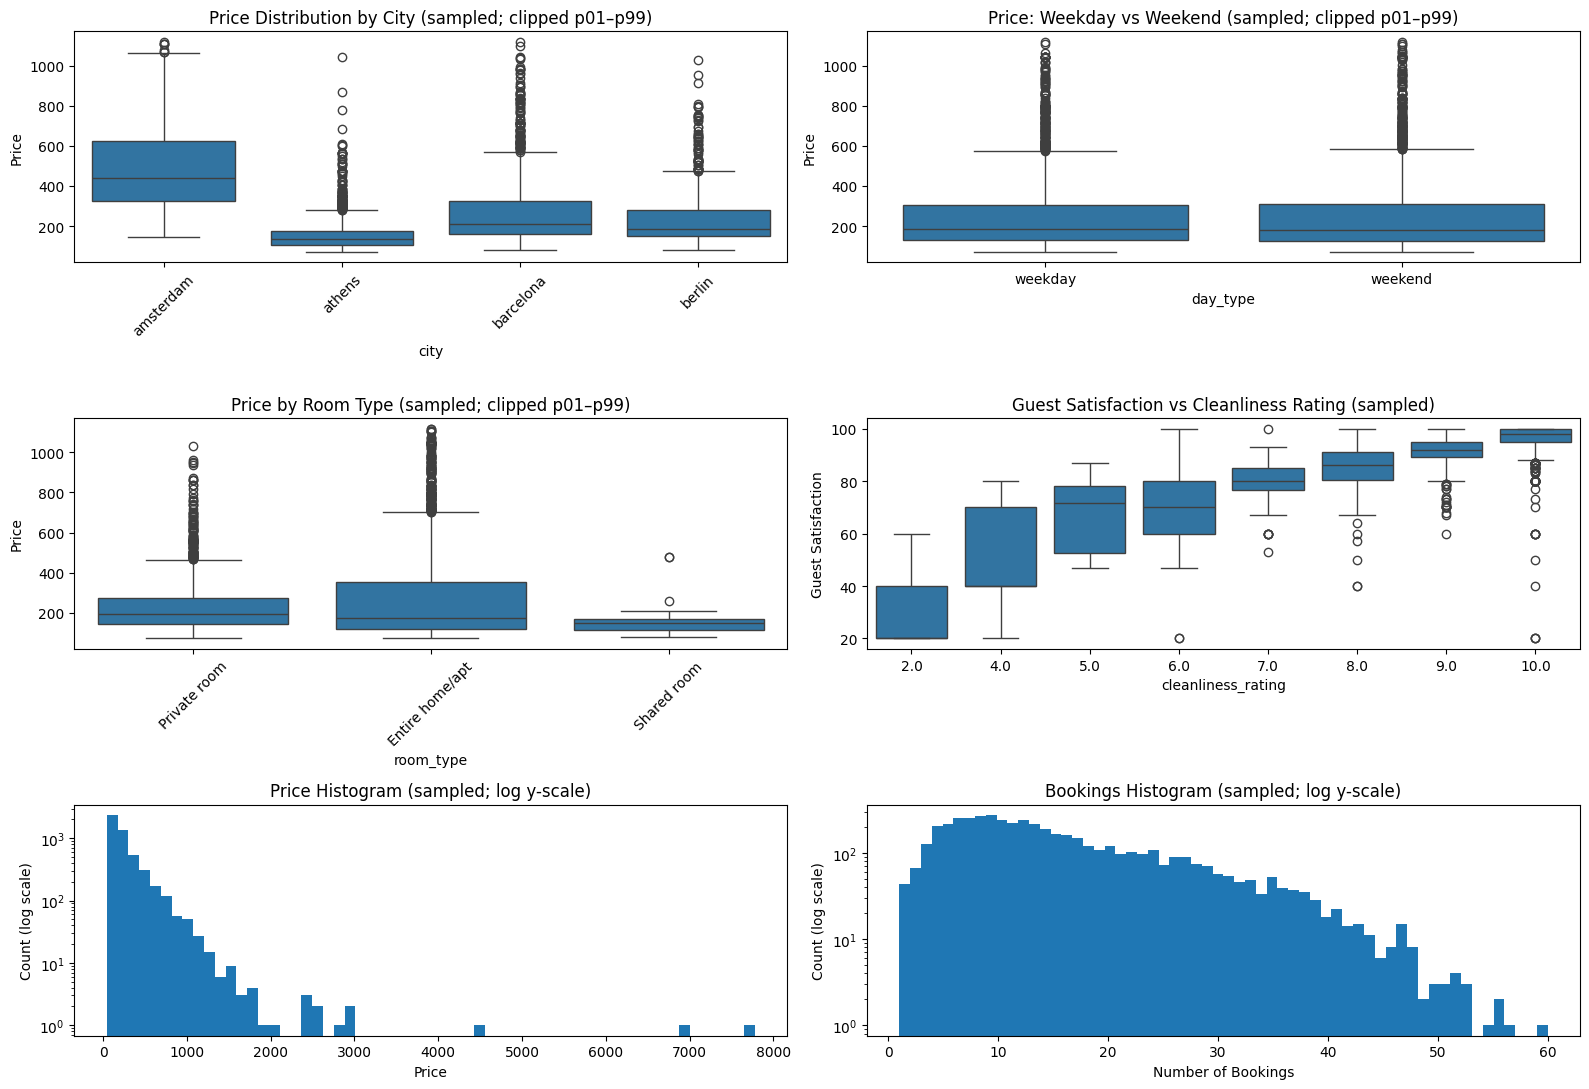

In [7]:
# Price Distribution Analysis (PySpark-first; collect only aggregates/samples for plotting)

from pyspark.sql import functions as F
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Basic data quality checks (prettier Spark → Pandas display)
cols = [
    c for c in [
        "listing_price", "city", "weekend", "room_type",
        "person_capacity", "city_center_dist", "metro_dist", 
        "n_bookings", "cleanliness_rating", "guest_satisfaction_overall",
    ] if c in df.columns
]

dq_exprs = [
    (F.mean(F.col(c).isNull().cast("double")) * 100).alias(c)
    for c in cols
]

dq_pdf = df.select(*dq_exprs).toPandas().T.reset_index()
dq_pdf.columns = ["column", "null_pct"]
dq_pdf["null_pct"] = dq_pdf["null_pct"].astype(float)

fmt_dq = {"null_pct": "{:.2f}%"}

display(
    dq_pdf.style.format(fmt_dq)
                 .set_table_attributes("style='width:50%; font-family: Arial; font-size:12px;'")
                 .set_caption("Null % (selected cols; Spark → Pandas)")
)

# Robust distribution stats overall + by segments (Spark aggregations)
price_stats_overall = df.agg(
    F.count("*").alias("n"),
    F.mean("listing_price").alias("mean"),
    F.expr("percentile_approx(listing_price, 0.5)").alias("median"),
    F.stddev("listing_price").alias("std"),
    F.min("listing_price").alias("min"),
    F.max("listing_price").alias("max"),
    F.expr("percentile_approx(listing_price, 0.1)").alias("p10"),
    F.expr("percentile_approx(listing_price, 0.9)").alias("p90"),
)

# Pretty-print overall price stats
overall_pdf = price_stats_overall.toPandas()
overall_pdf["n"] = overall_pdf["n"].astype(int)

fmt_overall = {
    "n": "{:,}",
    "mean": "{:,.2f}",
    "median": "{:,.2f}",
    "std": "{:,.2f}",
    "min": "{:,.2f}",
    "max": "{:,.2f}",
    "p10": "{:,.2f}",
    "p90": "{:,.2f}",
}

display(
    overall_pdf.style.format(fmt_overall)
                     .set_table_attributes("style='width:50%; font-family: Arial; font-size:12px;'")
                     .set_caption("Overall price stats (Spark → Pandas)")
)

# Segment-level summary table (recruiter-friendly)
segment_stats = (
    df.groupBy("city", "weekend")
      .agg(
          F.count("*").alias("n"),
          F.mean("listing_price").alias("avg_price"),
          F.expr("percentile_approx(listing_price, 0.5)").alias("median_price"),
          F.stddev("listing_price").alias("std_price"),
          F.expr("percentile_approx(listing_price, 0.1)").alias("p10"),
          F.expr("percentile_approx(listing_price, 0.9)").alias("p90"),
          F.mean("city_center_dist").alias("avg_dist"),
          F.mean("person_capacity").alias("avg_capacity"),
          F.mean("guest_satisfaction_overall").alias("avg_guest_satisfaction_overall"),
          F.min("listing_price").alias("min_price"),
          F.max("listing_price").alias("max_price"),
          F.mean("cleanliness_rating").alias("avg_cleanliness_rating"),
          F.mean("n_bookings").alias("avg_n_bookings"),
      )
      .orderBy("city", "weekend")
)

print("Price stats by city x weekend (Spark):")
segment_stats_pdf = segment_stats.limit(5000).toPandas().sort_values(["city", "weekend"])
segment_stats_pdf["n"] = segment_stats_pdf["n"].astype(int)

fmt_seg = {
    "n": "{:,}",
    "avg_price": "{:,.2f}",
    "median_price": "{:,.2f}",
    "std_price": "{:,.2f}",
    "p10": "{:,.2f}",
    "p90": "{:,.2f}",
    "avg_dist": "{:,.2f}",
    "avg_capacity": "{:,.2f}",
}

display(
    segment_stats_pdf.style.format(fmt_seg)
                     .set_table_attributes("style='width:90%; font-family: Arial; font-size:12px;'")
                     .set_caption("Price stats by city x weekend (Spark → Pandas)")
)

# Plotting using a bounded sample to avoid collecting full Spark DF
sample_n = 5000
plot_pdf = (
    df.select("city", "weekend", "room_type", "listing_price", "cleanliness_rating", "guest_satisfaction_overall", "n_bookings")
      .where(F.col("listing_price").isNotNull())
      .sample(withReplacement=False, fraction=0.4, seed=42)   # oversample then cap
      .limit(sample_n)
      .toPandas()
)

# Map weekend to readable labels for plots
if "weekend" in plot_pdf.columns:
    plot_pdf["day_type"] = plot_pdf["weekend"].map({0: "weekday", 1: "weekend"}).astype(str)

# Reduce the influence of extreme outliers for boxplots (keep full stats above)
p01, p99 = df.approxQuantile("listing_price", [0.01, 0.99], 0.001)
plot_pdf_clip = plot_pdf[(plot_pdf["listing_price"] >= p01) & (plot_pdf["listing_price"] <= p99)].copy()

fig, axes = plt.subplots(3, 2, figsize=(16, 11))

# By city
sns.boxplot(data=plot_pdf_clip, x="city", y="listing_price", ax=axes[0, 0])
axes[0, 0].set_title("Price Distribution by City (sampled; clipped p01–p99)")
axes[0, 0].set_ylabel("Price")
axes[0, 0].tick_params(axis="x", rotation=45)

# By day type (weekday vs weekend)
x_day = "day_type" if "day_type" in plot_pdf_clip.columns else "weekend"
sns.boxplot(data=plot_pdf_clip, x=x_day, y="listing_price", ax=axes[0, 1])
axes[0, 1].set_title("Price: Weekday vs Weekend (sampled; clipped p01–p99)")
axes[0, 1].set_ylabel("Price")

# By room type
sns.boxplot(data=plot_pdf_clip, x="room_type", y="listing_price", ax=axes[1, 0])
axes[1, 0].set_title("Price by Room Type (sampled; clipped p01–p99)")
axes[1, 0].set_ylabel("Price")
axes[1, 0].tick_params(axis="x", rotation=45)

# guest_satisfaction_overall vs price
sns.boxplot(data=plot_pdf, y="guest_satisfaction_overall", x="cleanliness_rating", ax=axes[1, 1])
axes[1, 1].set_title("Guest Satisfaction vs Cleanliness Rating (sampled)")
axes[1, 1].set_ylabel("Guest Satisfaction")

# Histogram (log-scale option is often useful for heavy-tailed price)
axes[2, 0].hist(plot_pdf["listing_price"], bins=60, log=True)
axes[2, 0].set_title("Price Histogram (sampled; log y-scale)")
axes[2, 0].set_xlabel("Price")
axes[2, 0].set_ylabel("Count (log scale)")

# Histogram (log-scale option is often useful for heavy-tailed price)
axes[2, 1].hist(plot_pdf["n_bookings"], bins=60, log=True)
axes[2, 1].set_title("Bookings Histogram (sampled; log y-scale)")
axes[2, 1].set_xlabel("Number of Bookings")
axes[2, 1].set_ylabel("Count (log scale)")


plt.tight_layout()

# Save to a deterministic project path
output_dir = project_root / "outputs"
output_dir.mkdir(parents=True, exist_ok=True)
plt.savefig(output_dir / "price_distributions.png", dpi=150)
plt.show()

Analyzing 6 numeric columns
Computing correlations...
  person_capacity: 0.2031
  cleanliness_rating: -0.0061
  guest_satisfaction_overall: -0.0019
  bedrooms: 0.2217
  city_center_dist: -0.0447
  metro_dist: -0.0610

Top 20 correlations:
                   feature    corr  abs_corr
                  bedrooms  0.2217    0.2217
           person_capacity  0.2031    0.2031
                metro_dist -0.0610    0.0610
          city_center_dist -0.0447    0.0447
        cleanliness_rating -0.0061    0.0061
guest_satisfaction_overall -0.0019    0.0019


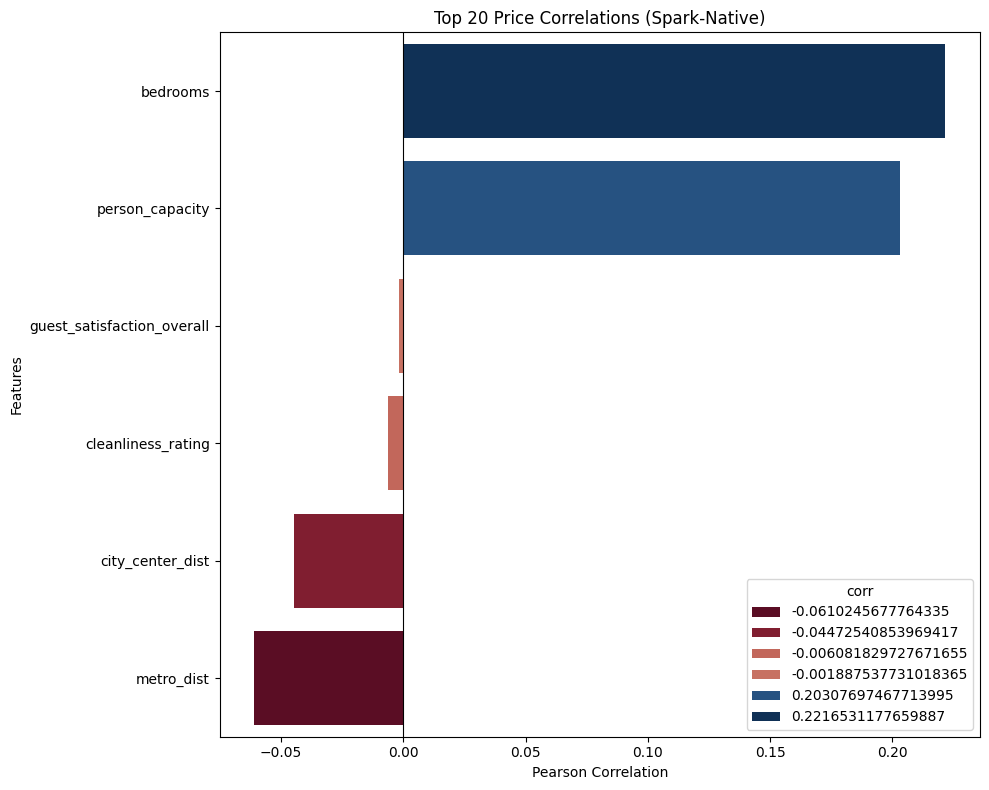

In [8]:
# Correlation Analysis
from pyspark.sql import functions as F
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pathlib import Path

# FORCE LOCAL MODE - CRITICAL for Windows
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "false")
spark.conf.set("spark.default.parallelism", "1") 
spark.conf.set("spark.sql.adaptive.enabled", "false")

# Get numeric columns (Spark-native, no collect)
numeric_cols = [f.name for f in df.schema.fields 
                if f.dataType.simpleString().lower() in {"double", "float", "integer", "long"}
                and f.name not in {"c0", "listing_price"}][:30]  # Limit 30 cols

print(f"Analyzing {len(numeric_cols)} numeric columns")

# SPARK-NATIVE correlations
print("Computing correlations...")
corr_dict = {}
for col in numeric_cols:
    try:
        corr_val = df.stat.corr("listing_price", col)
        corr_dict[col] = float(corr_val)
        print(f"  {col}: {corr_val:.4f}")
    except:
        corr_dict[col] = 0.0

# Pure Python sorting (tiny dict, no Spark)
corr_pdf = pd.DataFrame([
    {"feature": k, "corr": v, "abs_corr": abs(v)} 
    for k, v in corr_dict.items()
]).sort_values("abs_corr", ascending=False).head(20)

print("\nTop 20 correlations:")
print(corr_pdf.round(4).to_string(index=False))

# Plotting (tiny pandas df = safe)
plt.figure(figsize=(10, 8))
sns.barplot(data=corr_pdf.sort_values("corr", ascending=False), y="feature", x="corr", palette="RdBu", hue="corr")
plt.title("Top 20 Price Correlations (Spark-Native)")
plt.xlabel("Pearson Correlation")
plt.ylabel("Features")
plt.axvline(0, color='black', linewidth=0.8)
plt.tight_layout()

# Save
output_dir = Path(project_root) / "outputs"
output_dir.mkdir(parents=True, exist_ok=True)
plt.savefig(output_dir / "top_price_correlations.png", dpi=150, bbox_inches='tight')
plt.show()


Creating heatmap for top 6 features...


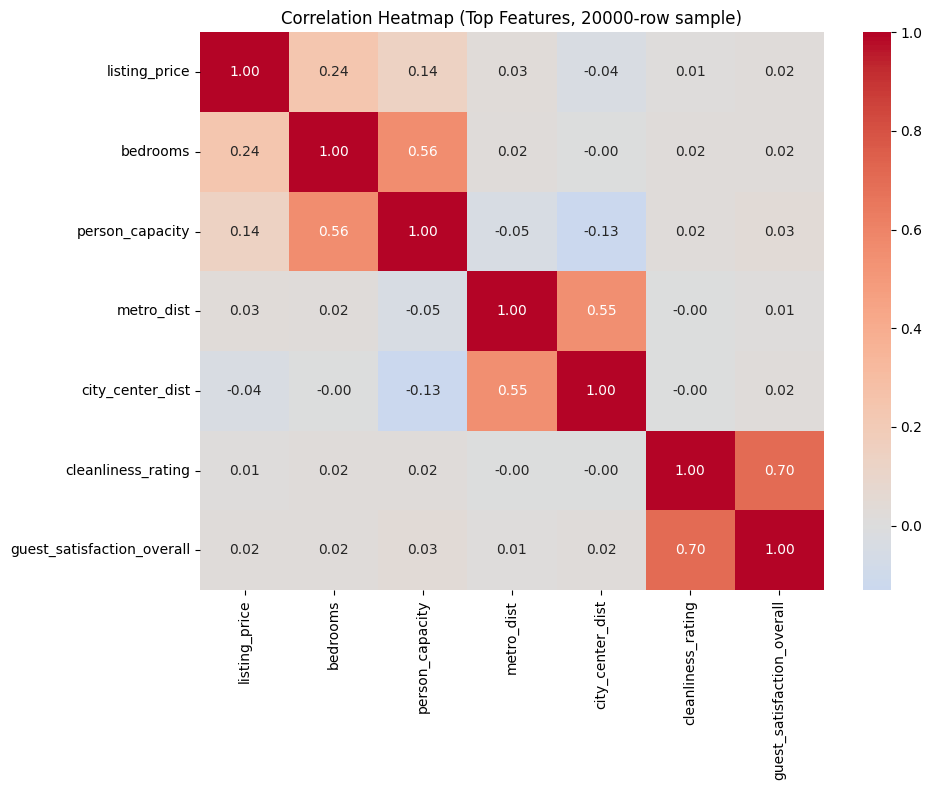

In [9]:
# Safe heatmap from top 10 features only
if len(corr_pdf) >= 10:
    top_features = corr_pdf.sort_values("abs_corr", ascending=False).head(10)["feature"].tolist()
else:
    top_features = corr_pdf["feature"].tolist()
print(f"Creating heatmap for top {len(top_features)} features...")

# Tiny sample → Pure Spark → toPandas SAFE
sample_cols = ["listing_price"] + top_features
heatmap_data = df.select(*sample_cols)\
                .where(F.col("listing_price").isNotNull())\
                .limit(20000).toPandas()

plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data.corr(numeric_only=True), 
            cmap="coolwarm", center=0, annot=True, fmt=".2f")
plt.title("Correlation Heatmap (Top Features, 20000-row sample)")
plt.tight_layout()
plt.savefig(output_dir / "correlation_heatmap_safe.png", dpi=150)
plt.show()



Processing city: amsterdam ...


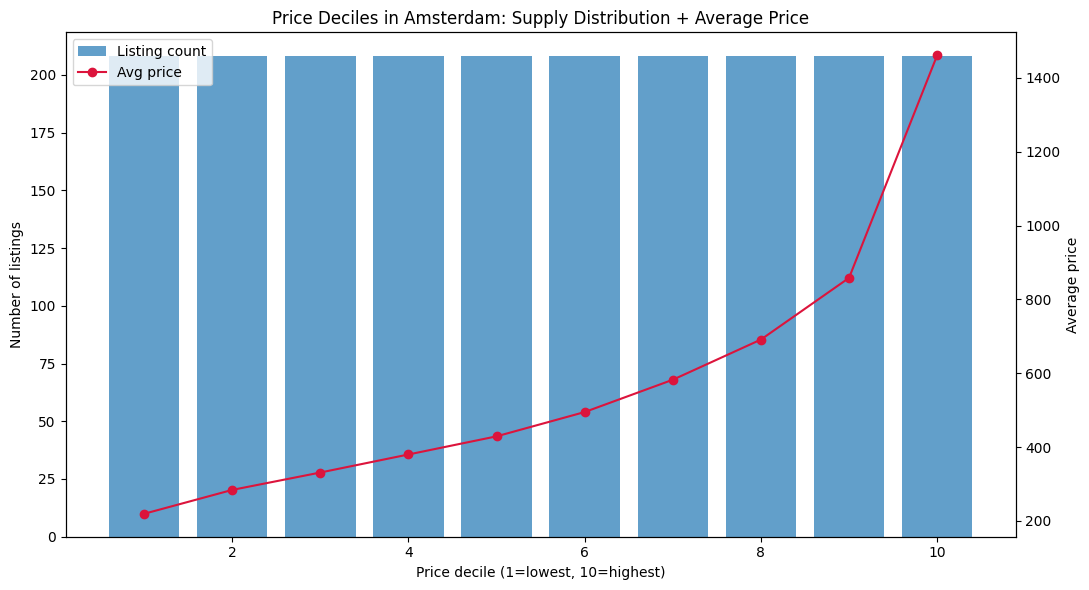


Processing city: athens ...


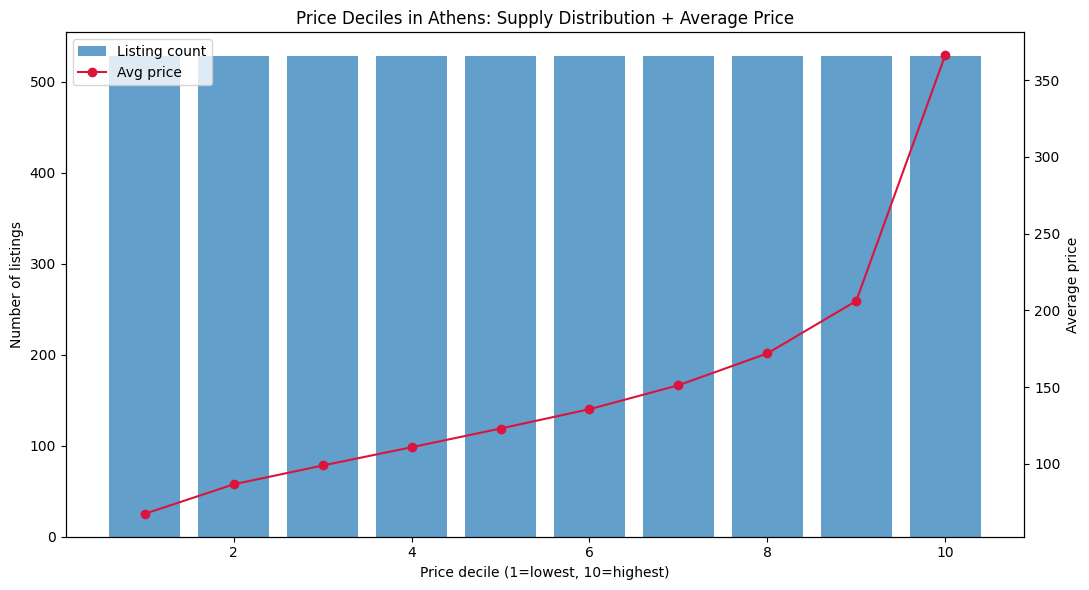


Processing city: barcelona ...


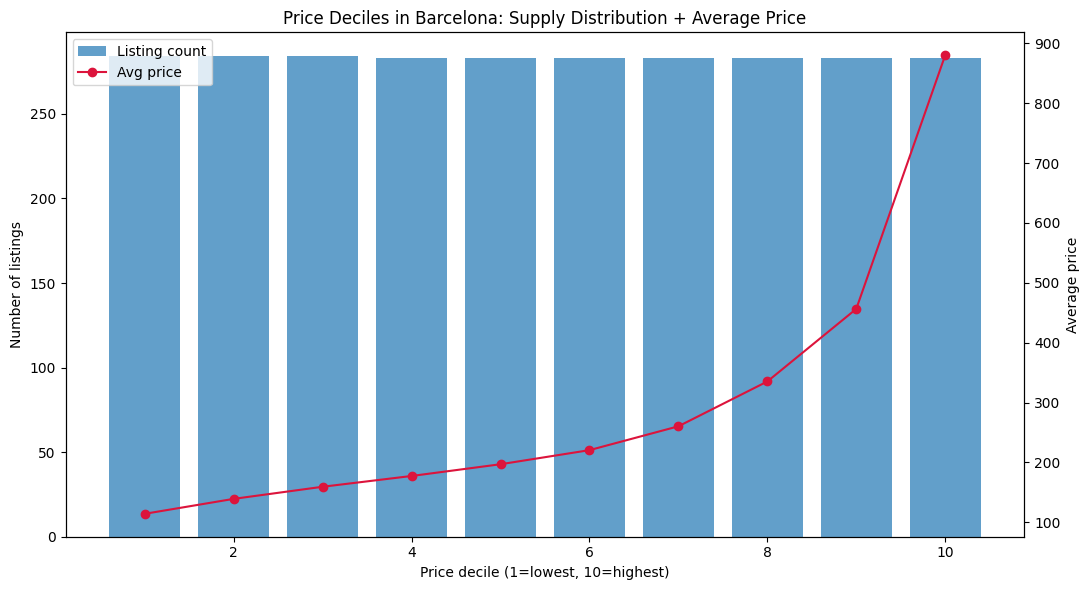


Processing city: berlin ...


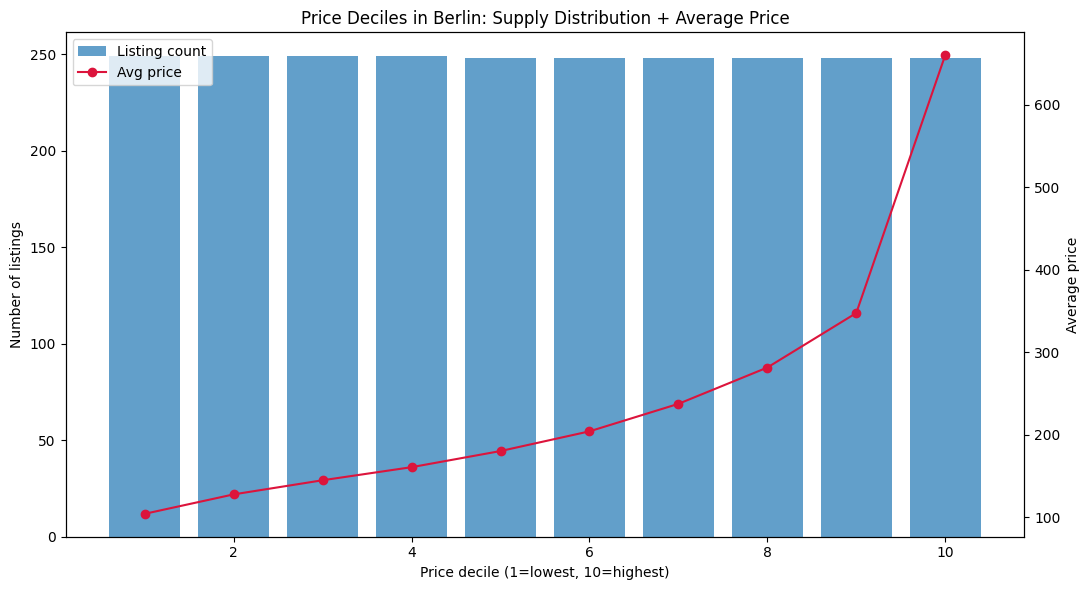


Processing city: budapest ...


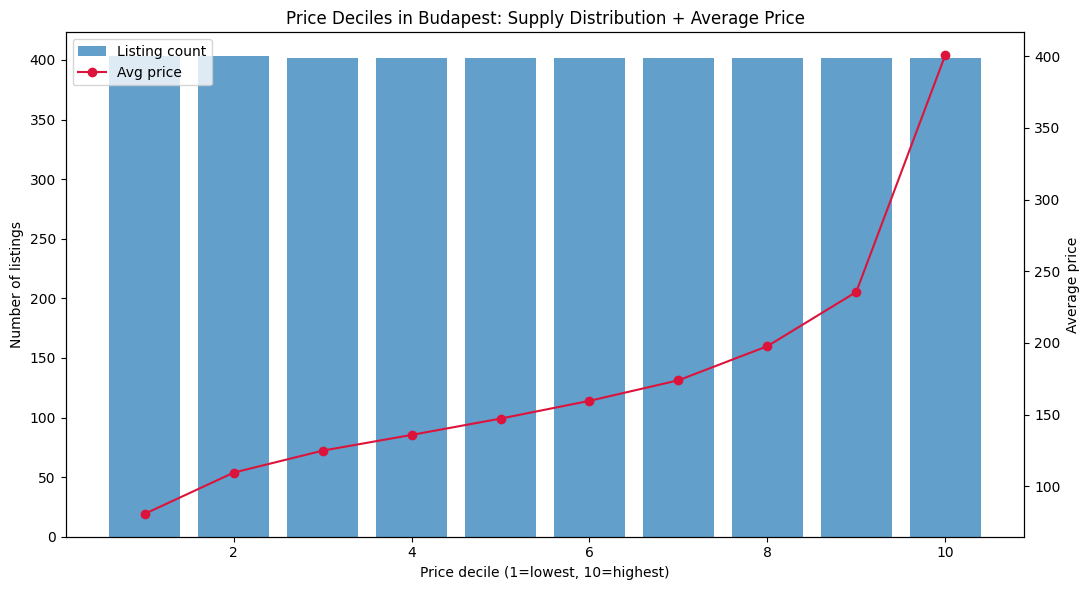


Processing city: lisbon ...


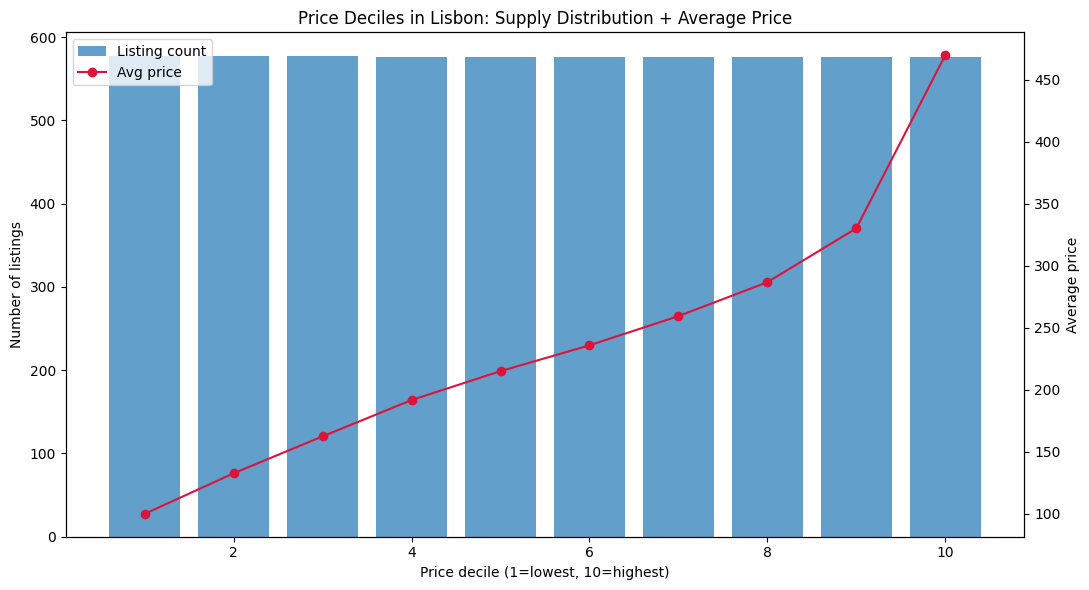


Processing city: london ...


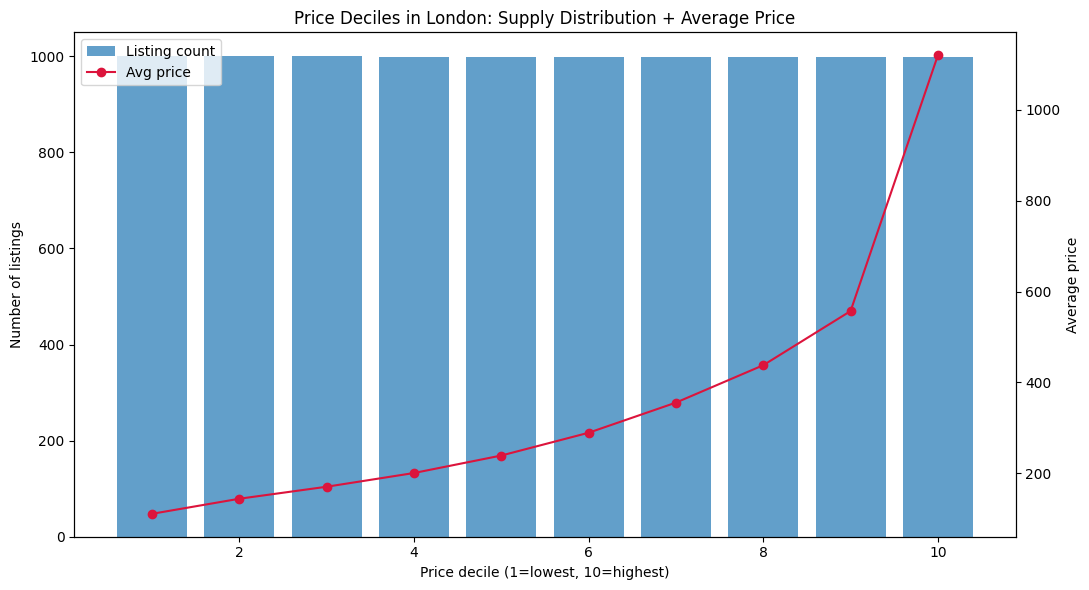


Processing city: paris ...


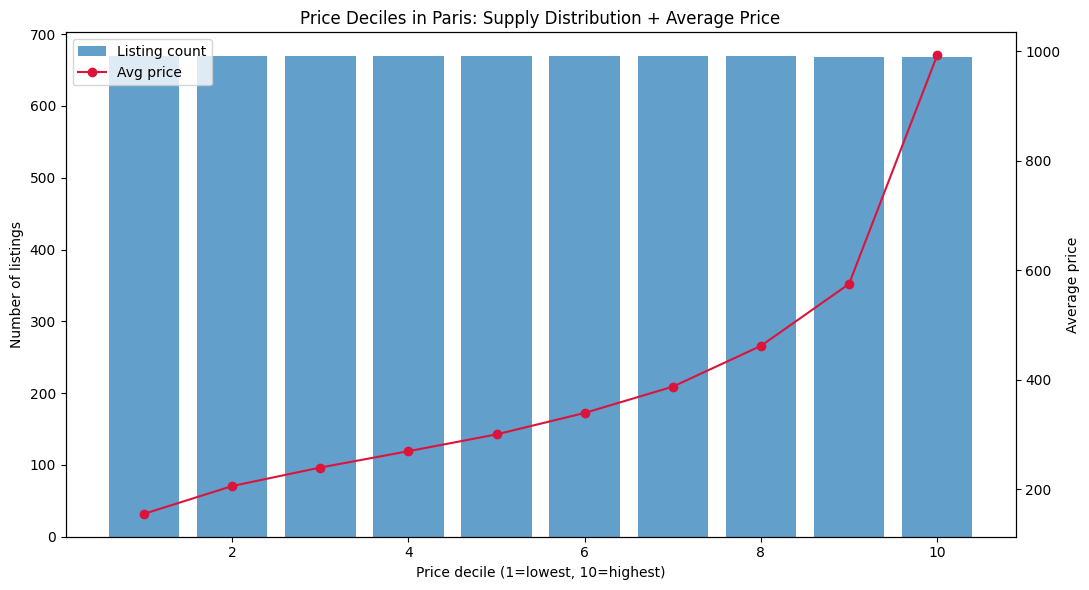


Processing city: rome ...


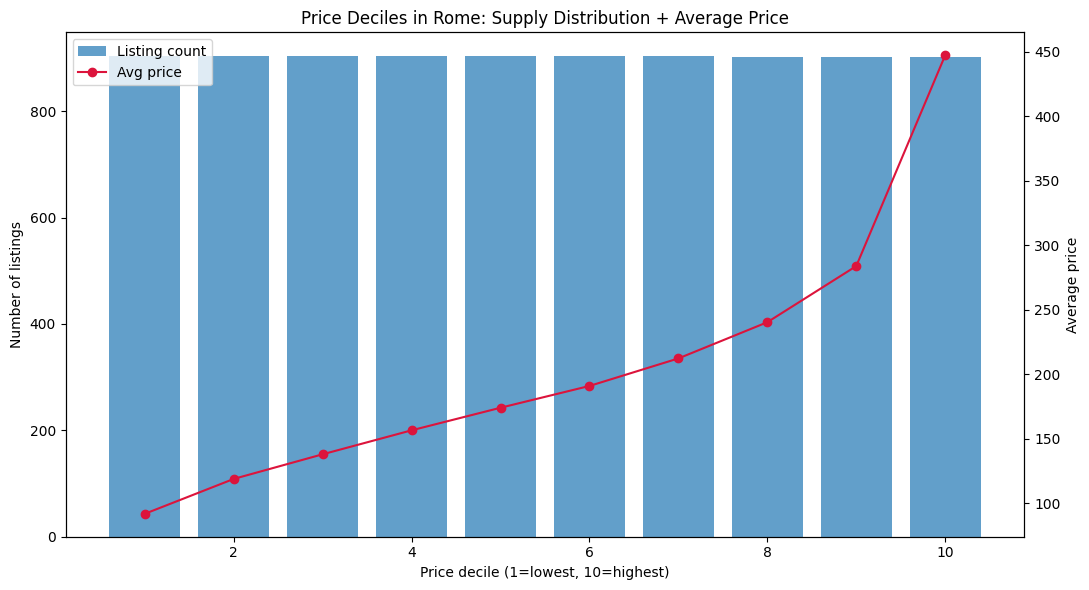


Processing city: vienna ...


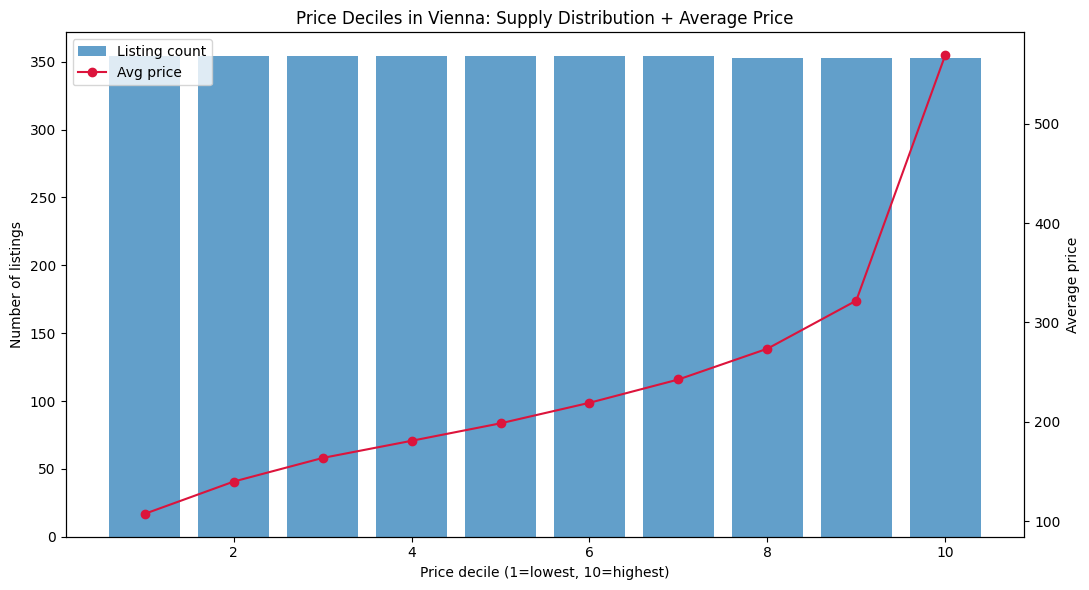

In [11]:
# Price Segmentation and Analysis (Spark deciles via ntile)

from pyspark.sql import functions as F
from pyspark.sql.window import Window
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np

# Plot: Supply distribution + avg price by decile for each city
city_list = ['amsterdam','athens','barcelona','berlin','budapest','lisbon','london','paris','rome','vienna']
for city in city_list:
    print(f"\nProcessing city: {city} ...")
    df_city = df.where((F.col("listing_price").isNotNull()) & (F.col("city") == city))
    
    # Create price deciles using Spark window
    w = Window.orderBy(F.col("listing_price").asc())
    df_deciles_city = df_city.withColumn("price_decile", F.ntile(10).over(w))

    price_deciles_spark_city = (
        df_deciles_city.groupBy("price_decile")
          .agg(
              F.count("*").alias("listing_count"),
              F.mean("listing_price").alias("avg_price"),
              F.expr("percentile_approx(listing_price, 0.5)").alias("median_price"),
              F.mean("guest_satisfaction_overall").alias("avg_satisfaction"),
              F.mean("cleanliness_rating").alias("avg_cleanliness"),
              F.mean("person_capacity").alias("avg_capacity"),
              F.mean("city_center_dist").alias("avg_dist"),
              F.mean("n_bookings").alias("avg_bookings"),
          )
          .orderBy("price_decile")
    )

    # Pretty-print Spark aggregate via a styled Pandas DataFrame
    price_deciles_pdf_city = price_deciles_spark_city.limit(5000).toPandas().sort_values("price_decile")
    price_deciles_pdf_city["listing_count"] = price_deciles_pdf_city["listing_count"].astype(int)

    # Formatting dict for deciles table (was missing 'fmt' variable)
    fmt_deciles = {
        "listing_count": "{:,}",
        "avg_price": "{:,.2f}",
        "median_price": "{:,.2f}",
        "avg_satisfaction": "{:.2f}",
        "avg_cleanliness": "{:.2f}",
        "avg_capacity": "{:.2f}",
        "avg_dist": "{:.2f}",
        "avg_bookings": "{:.2f}",
    }

    display(
        price_deciles_pdf_city.style.format(fmt_deciles)
                           .set_table_attributes("style='width:80%; font-family: Arial; font-size:12px;'")
                           .set_caption(f"Price deciles summary for {city.capitalize()} (Spark → Pandas)")
    )

    # Plot Supply distribution + avg price by decile
    fig, ax1 = plt.subplots(figsize=(11, 6))
    ax2 = ax1.twinx()

    ax1.bar(price_deciles_pdf_city["price_decile"], price_deciles_pdf_city["listing_count"], alpha=0.7, label="Listing count")
    ax2.plot(price_deciles_pdf_city["price_decile"], price_deciles_pdf_city["avg_price"], color="crimson", marker="o", label="Avg price")

    ax1.set_xlabel("Price decile (1=lowest, 10=highest)")
    ax1.set_ylabel("Number of listings")
    ax2.set_ylabel("Average price")
    ax1.set_title(f"Price Deciles in {city.capitalize()}: Supply Distribution + Average Price")
    # Combined legend
    lines, labels = [], []
    for ax in (ax1, ax2):
        l, lab = ax.get_legend_handles_labels()
        lines += l
        labels += lab
    ax1.legend(lines, labels, loc="upper left")
    plt.tight_layout()
    plt.savefig(output_dir / f"price_deciles_supply_{city}.png", dpi=150)
    plt.show()


## Price Elasticity of Demand

**Price elasticity of demand** measures how sensitive quantity demanded is to price changes. It's calculated as the percentage change in quantity demanded divided by the percentage change in price. [economicshelp](https://www.economicshelp.org/microessays/equilibrium/price-elasticity-demand/)

### Interpretation

- **Elastic demand (elasticity < -1)**: A 1% price increase causes more than 1% decrease in demand. For example, if elasticity = -2.0, a 10% price increase leads to a 20% drop in quantity demanded. [economicshelp](https://www.economicshelp.org/microessays/equilibrium/price-elasticity-demand/)

- **Unit elastic (elasticity = -1)**: A 1% price increase causes exactly 1% decrease in demand. Revenue remains constant regardless of price changes. [en.wikipedia](https://en.wikipedia.org/wiki/Price_elasticity_of_demand)

- **Inelastic demand (-1 < elasticity < 0)**: A 1% price increase causes less than 1% decrease in demand. For example, if elasticity = -0.5, a 10% price increase only reduces demand by 5%. [en.wikipedia](https://en.wikipedia.org/wiki/Price_elasticity_of_demand)

### Pricing Strategy Recommendations

- **For elastic goods**: Keep prices competitive and avoid increases, as small price hikes cause large demand losses. Focus on volume over margin. [blog.blackcurve](https://blog.blackcurve.com/price-elasticity-a-simple-explanation)

- **For inelastic goods**: You can raise prices to increase revenue, since demand won't fall proportionally. These are typically necessities with few substitutes. [corporatefinanceinstitute](https://corporatefinanceinstitute.com/resources/economics/price-elasticity/)

- **General rule**: When demand is inelastic, raising prices increases total revenue. When demand is elastic, lowering prices increases total revenue. [en.wikipedia](https://en.wikipedia.org/wiki/Price_elasticity_of_demand)


Processing elasticity for city: AMSTERDAM

  WEEKDAY:
    ✓ Two-regime fit detected (breakpoint at bin 4/25)
      Region 1 (4 bins): slope=-0.2168 (inelastic), R²=0.8387
      Region 2 (21 bins): slope=-0.6588 (inelastic), R²=0.9757
      Slope difference: 0.4420 | Breakpoint log(price)=5.6399 (price ~$281)


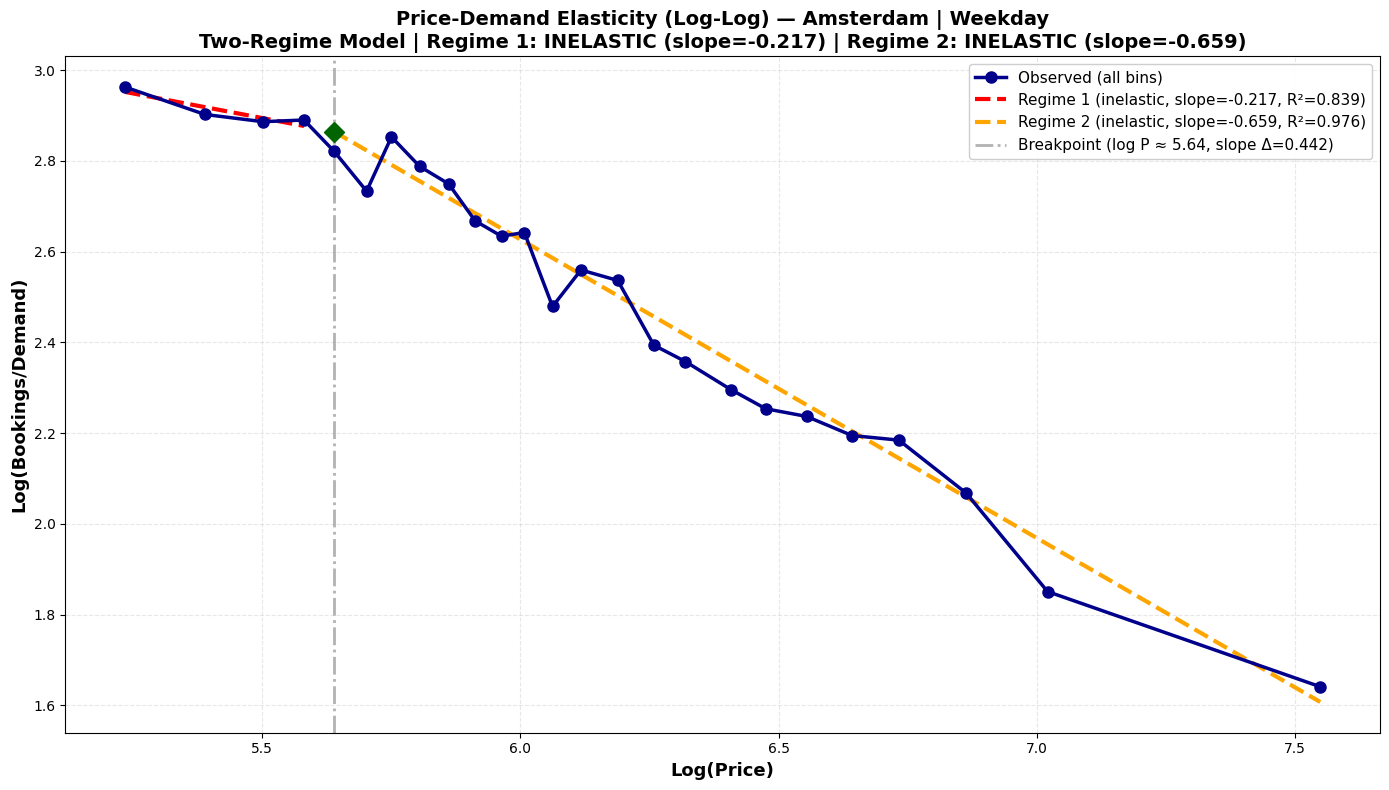


  WEEKEND:
    ✓ Two-regime fit detected (breakpoint at bin 4/25)
      Region 1 (4 bins): slope=-0.2137 (inelastic), R²=0.8616
      Region 2 (21 bins): slope=-0.6880 (inelastic), R²=0.9769
      Slope difference: 0.4743 | Breakpoint log(price)=5.7785 (price ~$323)


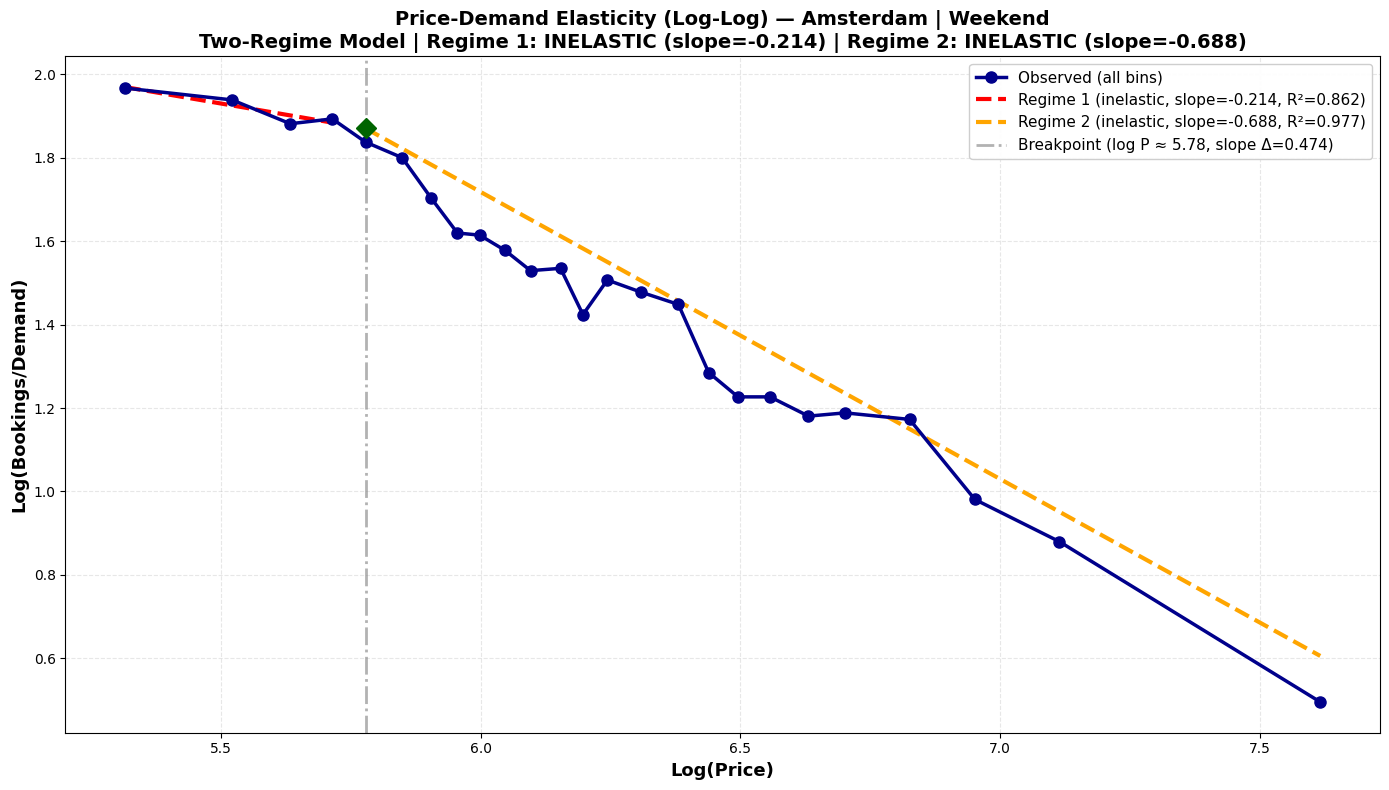


Processing elasticity for city: ATHENS

  WEEKDAY:
    ✓ Two-regime fit detected (breakpoint at bin 9/25)
      Region 1 (9 bins): slope=-0.0301 (highly_inelastic), R²=0.0595
      Region 2 (16 bins): slope=-0.3615 (inelastic), R²=0.9527
      Slope difference: 0.3314 | Breakpoint log(price)=4.7458 (price ~$115)


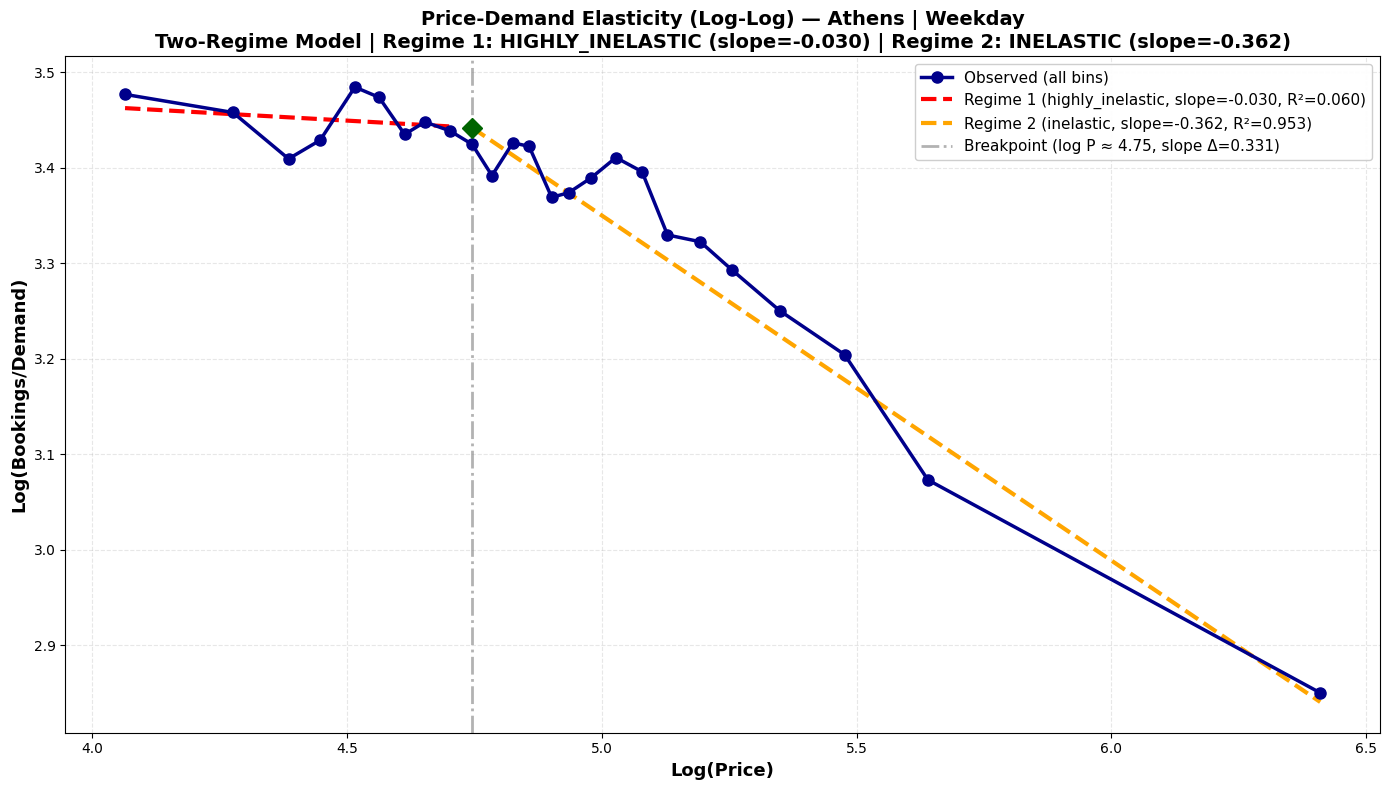


  WEEKEND:
    ✓ Two-regime fit detected (breakpoint at bin 7/25)
      Region 1 (7 bins): slope=0.0770 (highly_inelastic), R²=0.3066
      Region 2 (18 bins): slope=-0.3852 (inelastic), R²=0.9059
      Slope difference: 0.4621 | Breakpoint log(price)=4.6465 (price ~$104)


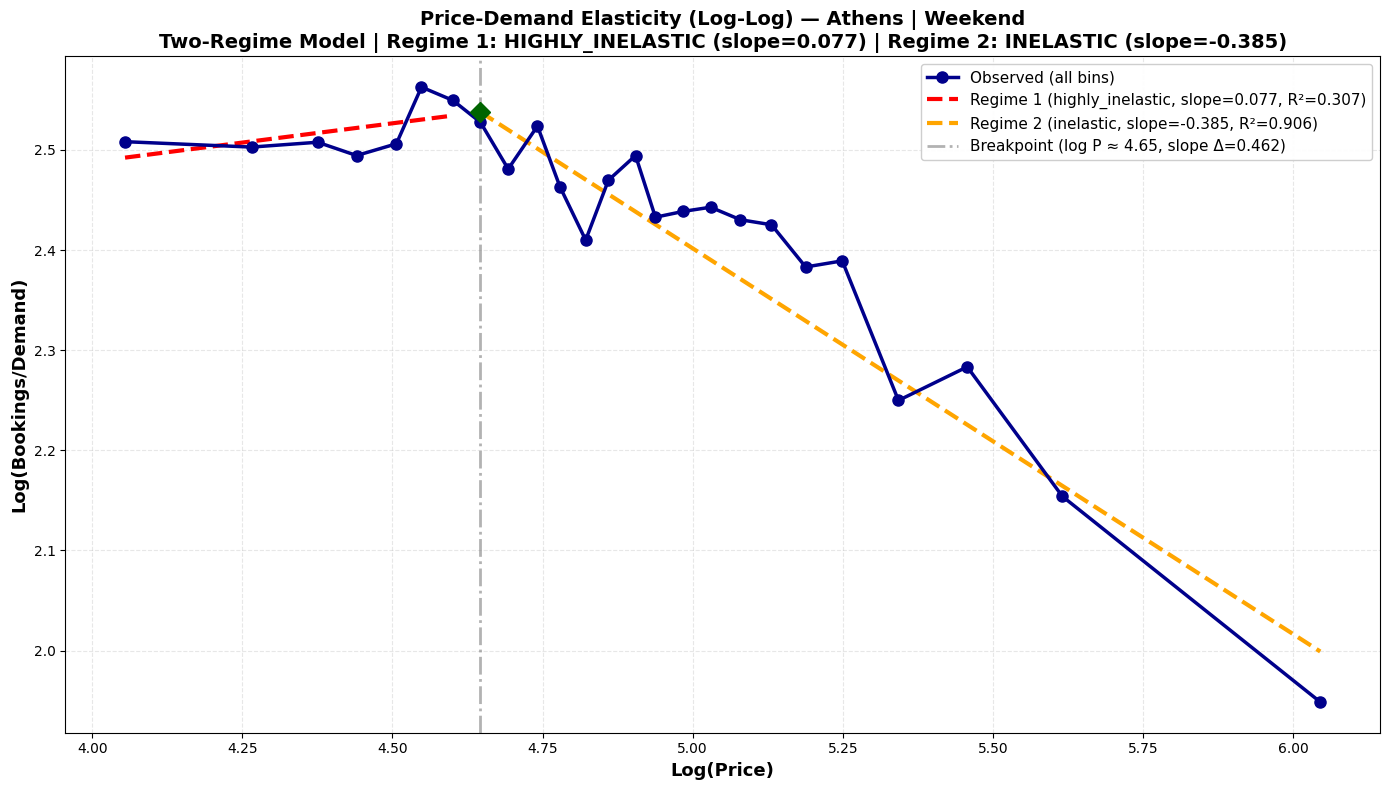


Processing elasticity for city: BARCELONA

  WEEKDAY:
    ✓ Two-regime fit detected (breakpoint at bin 9/25)
      Region 1 (9 bins): slope=-0.2103 (inelastic), R²=0.6287
      Region 2 (16 bins): slope=-0.5372 (inelastic), R²=0.9620
      Slope difference: 0.3269 | Breakpoint log(price)=5.2148 (price ~$184)


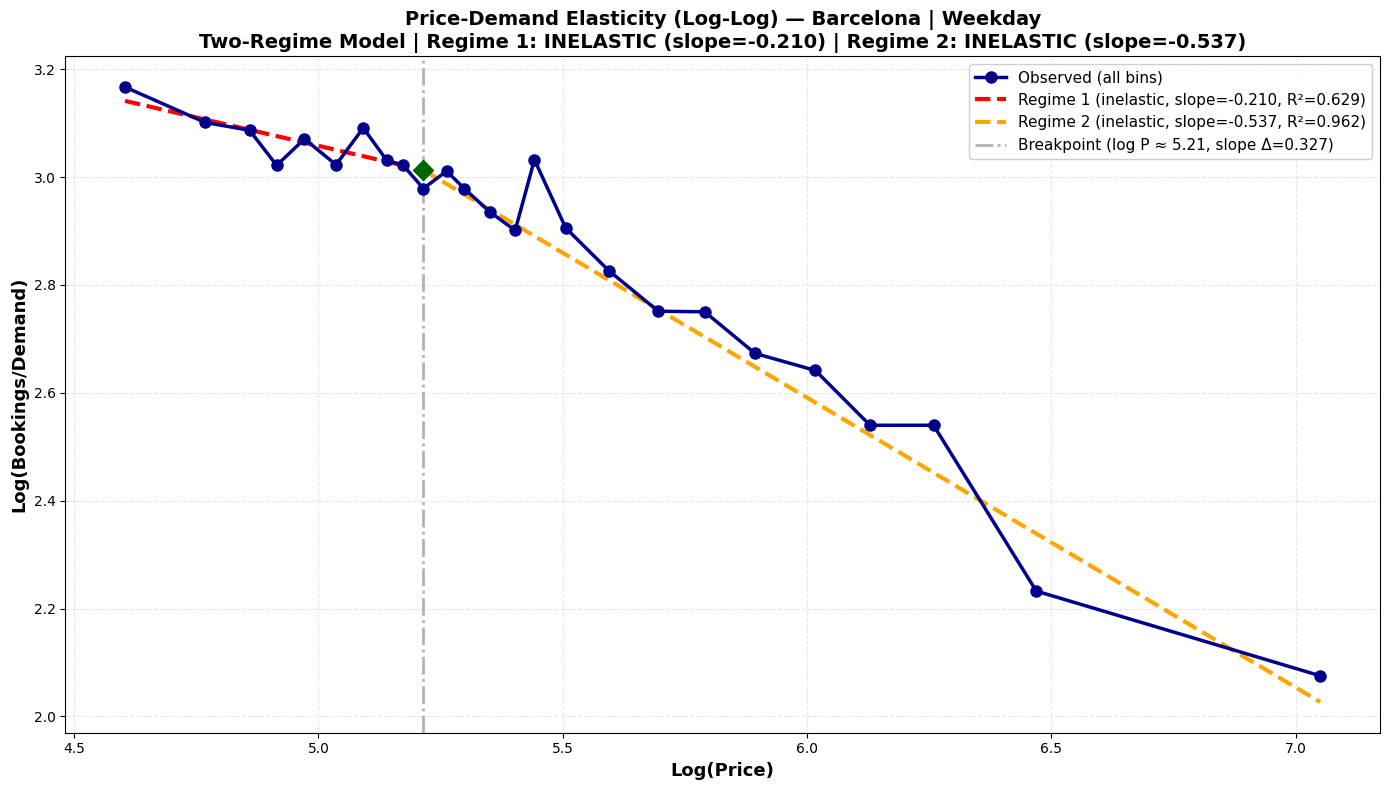


  WEEKEND:
    ✓ Two-regime fit detected (breakpoint at bin 8/25)
      Region 1 (8 bins): slope=-0.0182 (highly_inelastic), R²=0.0040
      Region 2 (17 bins): slope=-0.5267 (inelastic), R²=0.9593
      Slope difference: 0.5085 | Breakpoint log(price)=5.1568 (price ~$174)


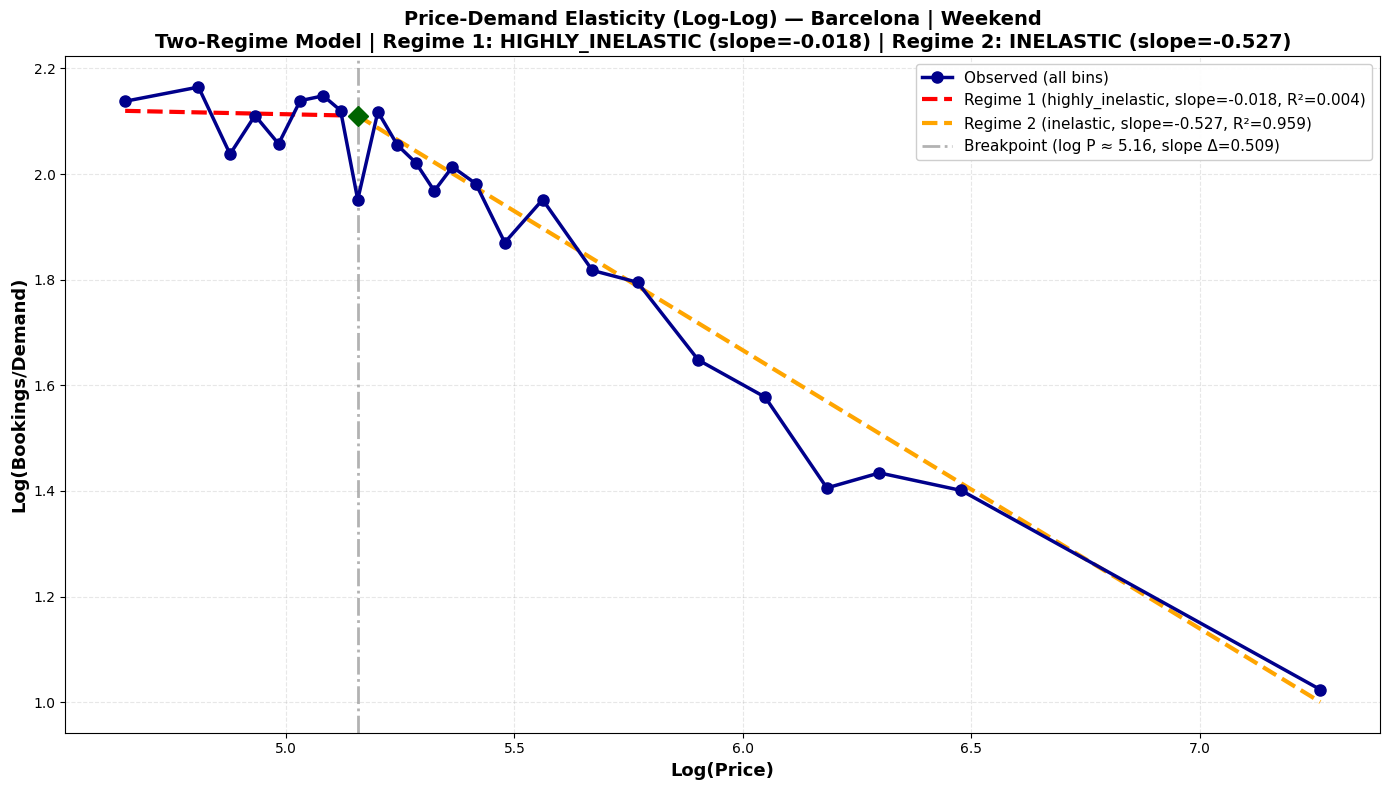


Processing elasticity for city: BERLIN

  WEEKDAY:
    ✓ Two-regime fit detected (breakpoint at bin 4/25)
      Region 1 (4 bins): slope=0.0838 (highly_inelastic), R²=0.4317
      Region 2 (21 bins): slope=-0.5005 (inelastic), R²=0.9508
      Slope difference: 0.5844 | Breakpoint log(price)=4.8852 (price ~$132)


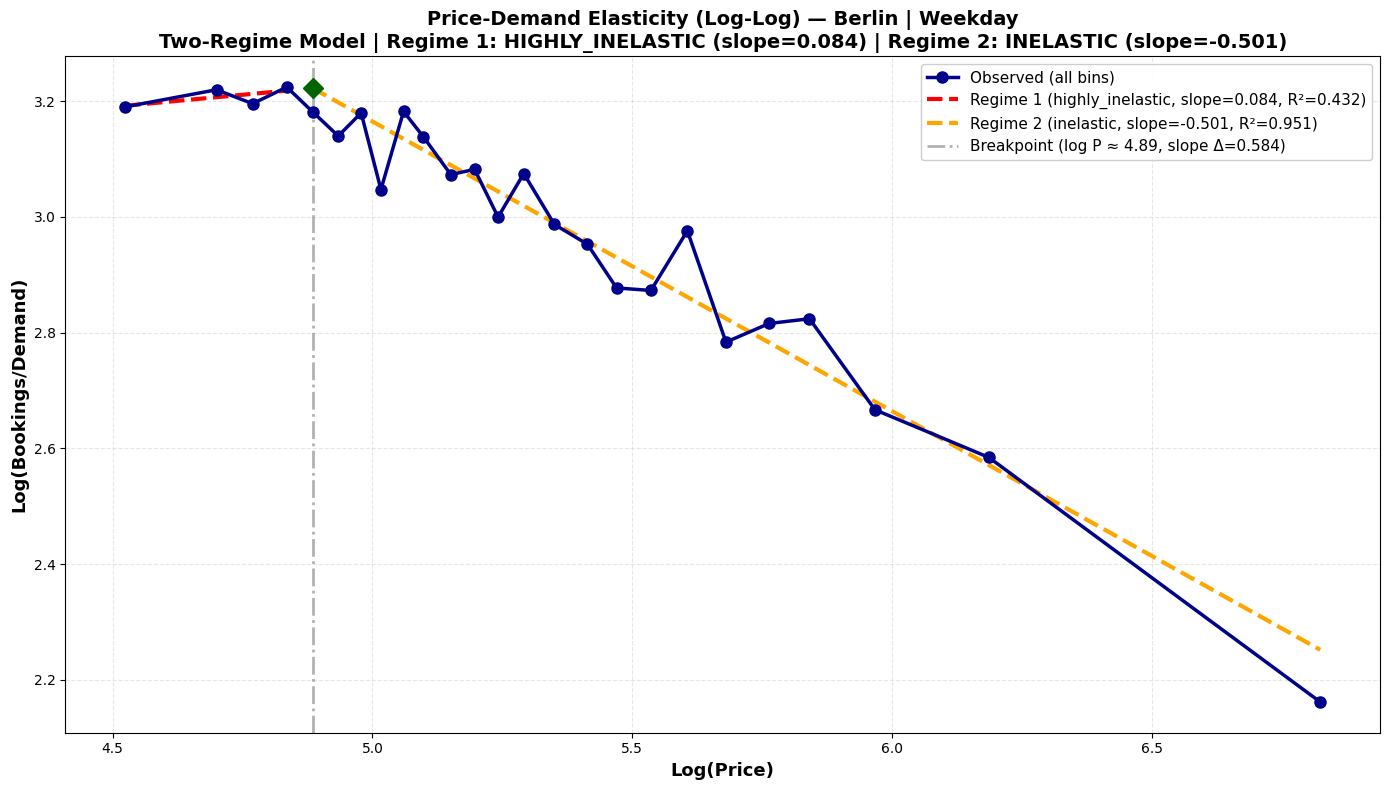


  WEEKEND:
    ✓ Two-regime fit detected (breakpoint at bin 4/25)
      Region 1 (4 bins): slope=0.1065 (highly_inelastic), R²=0.2650
      Region 2 (21 bins): slope=-0.5420 (inelastic), R²=0.9746
      Slope difference: 0.6485 | Breakpoint log(price)=4.8960 (price ~$134)


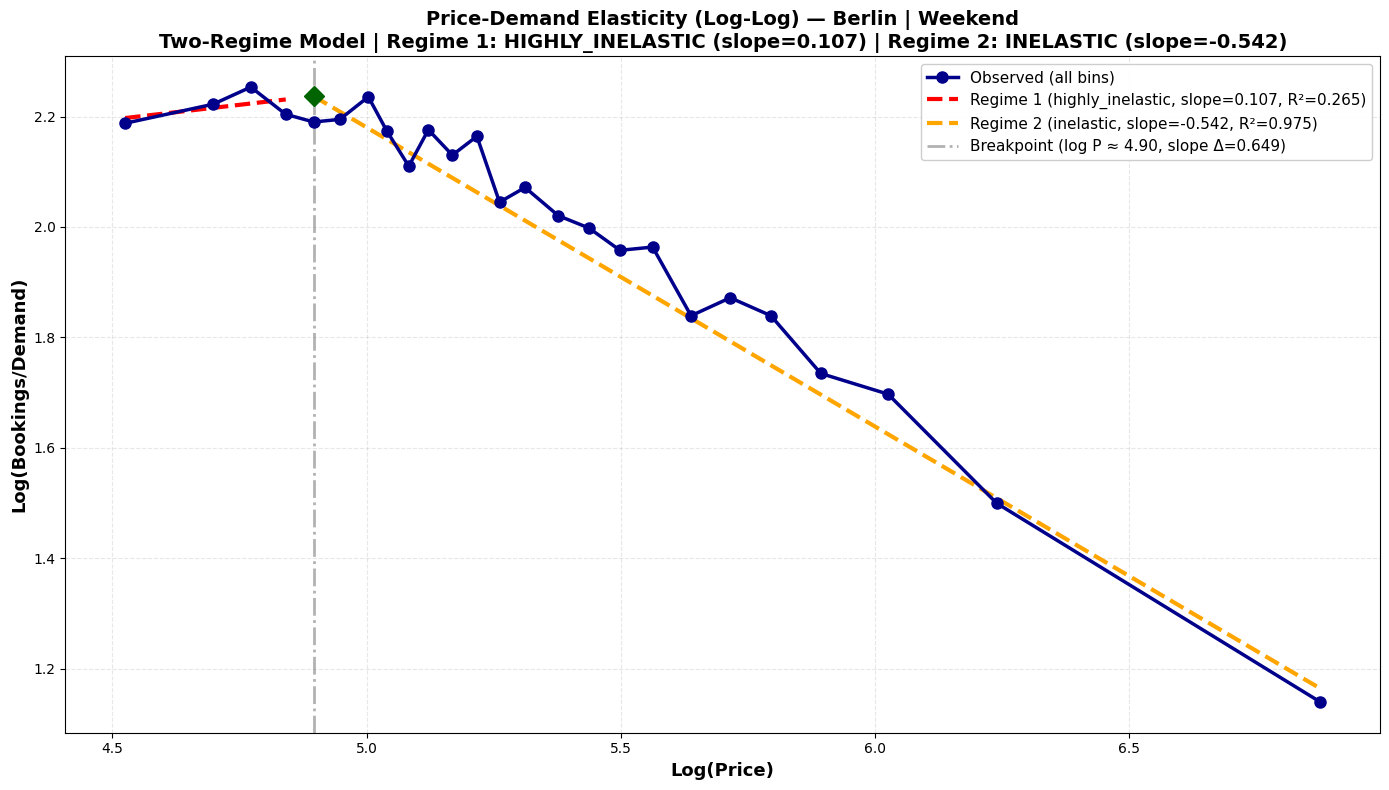


Processing elasticity for city: BUDAPEST

  WEEKDAY:
    ✓ Two-regime fit detected (breakpoint at bin 6/25)
      Region 1 (6 bins): slope=-0.0804 (highly_inelastic), R²=0.5152
      Region 2 (19 bins): slope=-0.3973 (inelastic), R²=0.9441
      Slope difference: 0.3169 | Breakpoint log(price)=4.8168 (price ~$124)


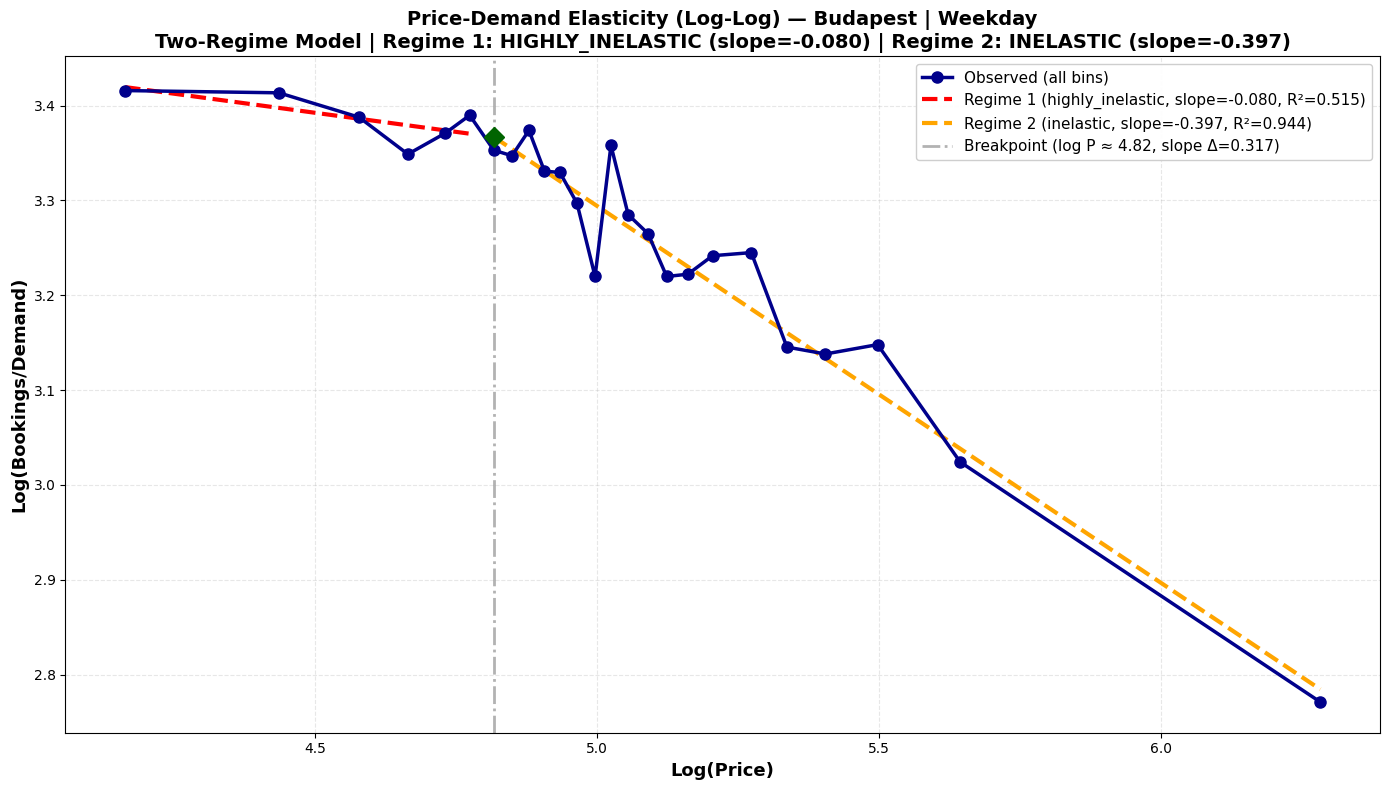


  WEEKEND:
    ✓ Two-regime fit detected (breakpoint at bin 5/25)
      Region 1 (5 bins): slope=-0.0141 (highly_inelastic), R²=0.0291
      Region 2 (20 bins): slope=-0.4803 (inelastic), R²=0.9590
      Slope difference: 0.4663 | Breakpoint log(price)=4.8239 (price ~$124)


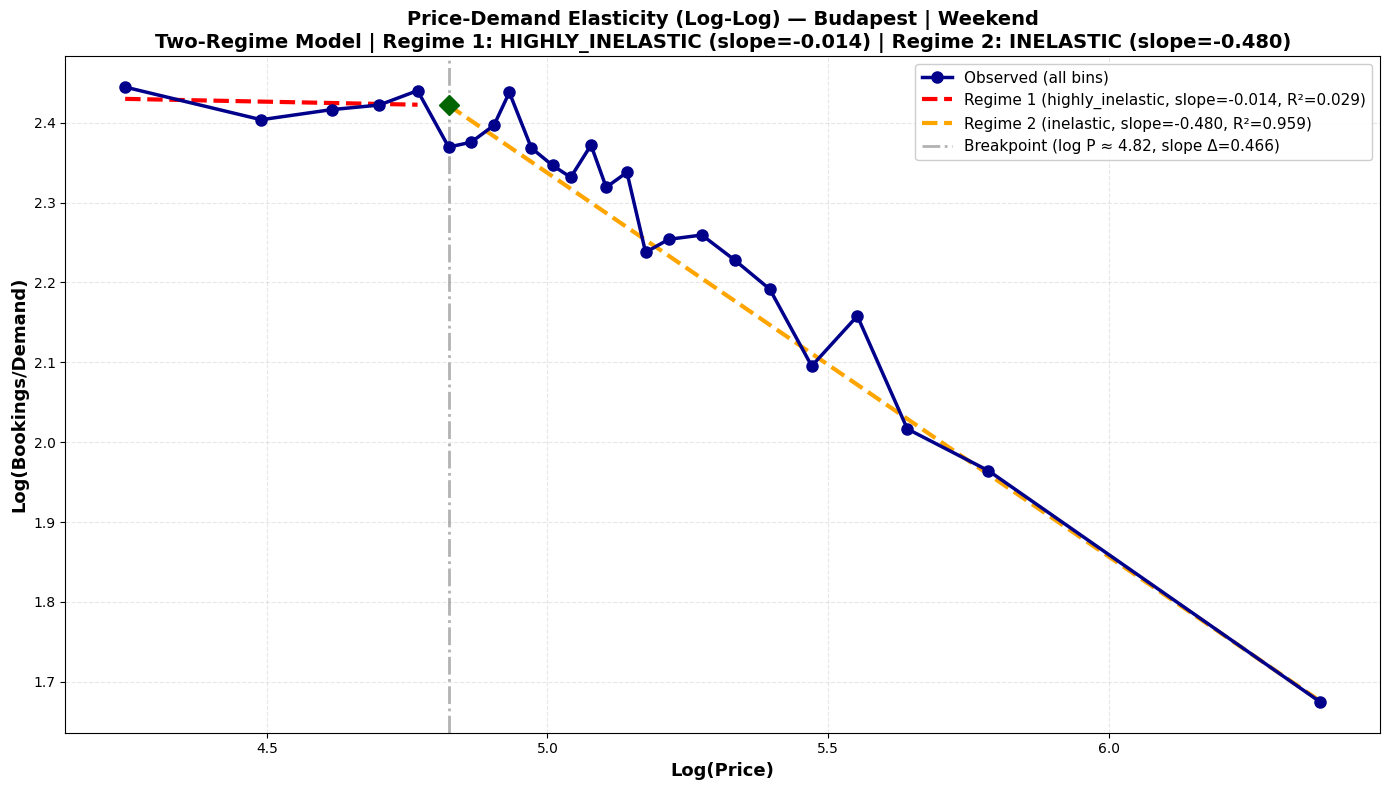


Processing elasticity for city: LISBON

  WEEKDAY:
    ✓ Single-regime fit (slope difference 0.2583 not significant enough)
      Slope=-0.2779 (inelastic), R²=0.8787


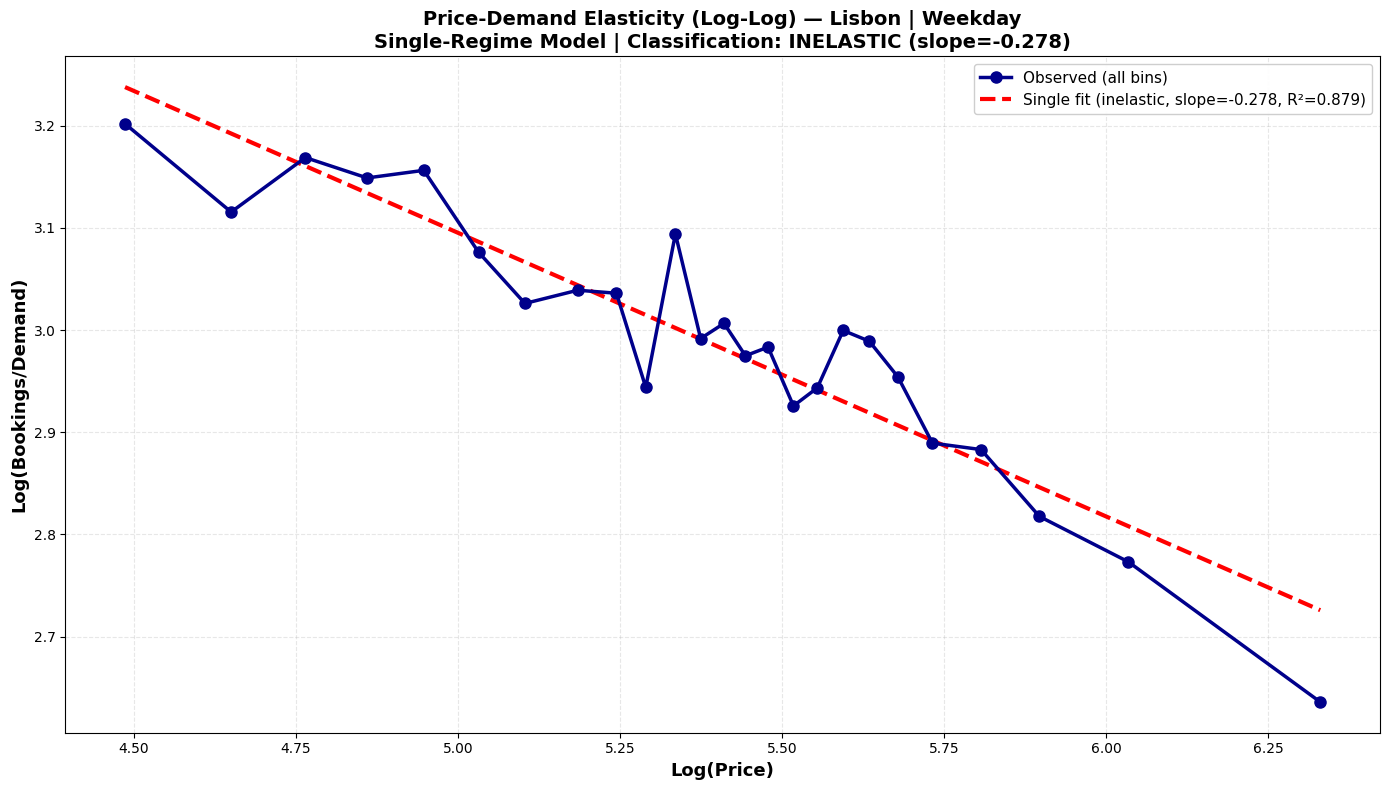


  WEEKEND:
    ✓ Single-regime fit (slope difference 0.1747 not significant enough)
      Slope=-0.3305 (inelastic), R²=0.9254


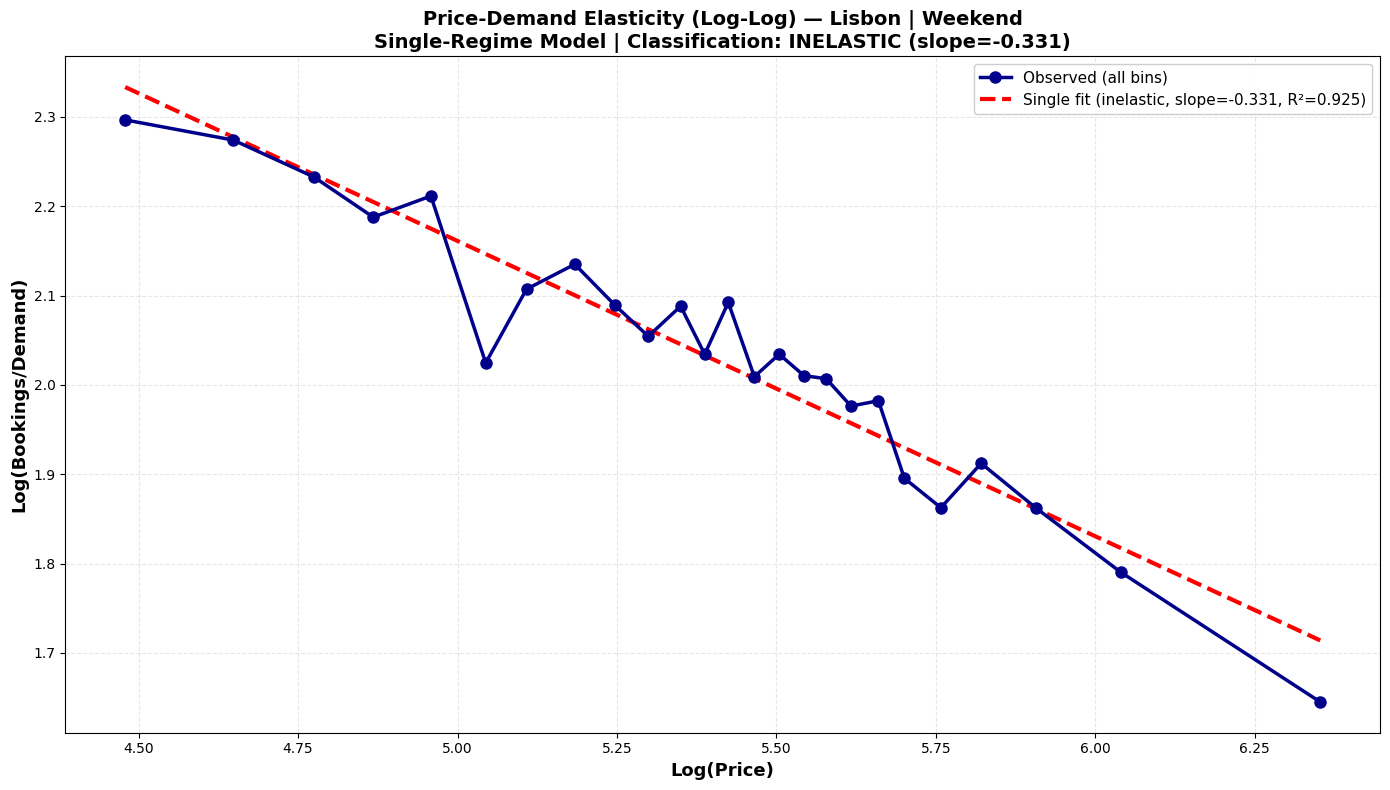


Processing elasticity for city: LONDON

  WEEKDAY:
    ✓ Two-regime fit detected (breakpoint at bin 6/25)
      Region 1 (6 bins): slope=-0.0669 (highly_inelastic), R²=0.3845
      Region 2 (19 bins): slope=-0.5615 (inelastic), R²=0.9915
      Slope difference: 0.4946 | Breakpoint log(price)=5.1297 (price ~$169)


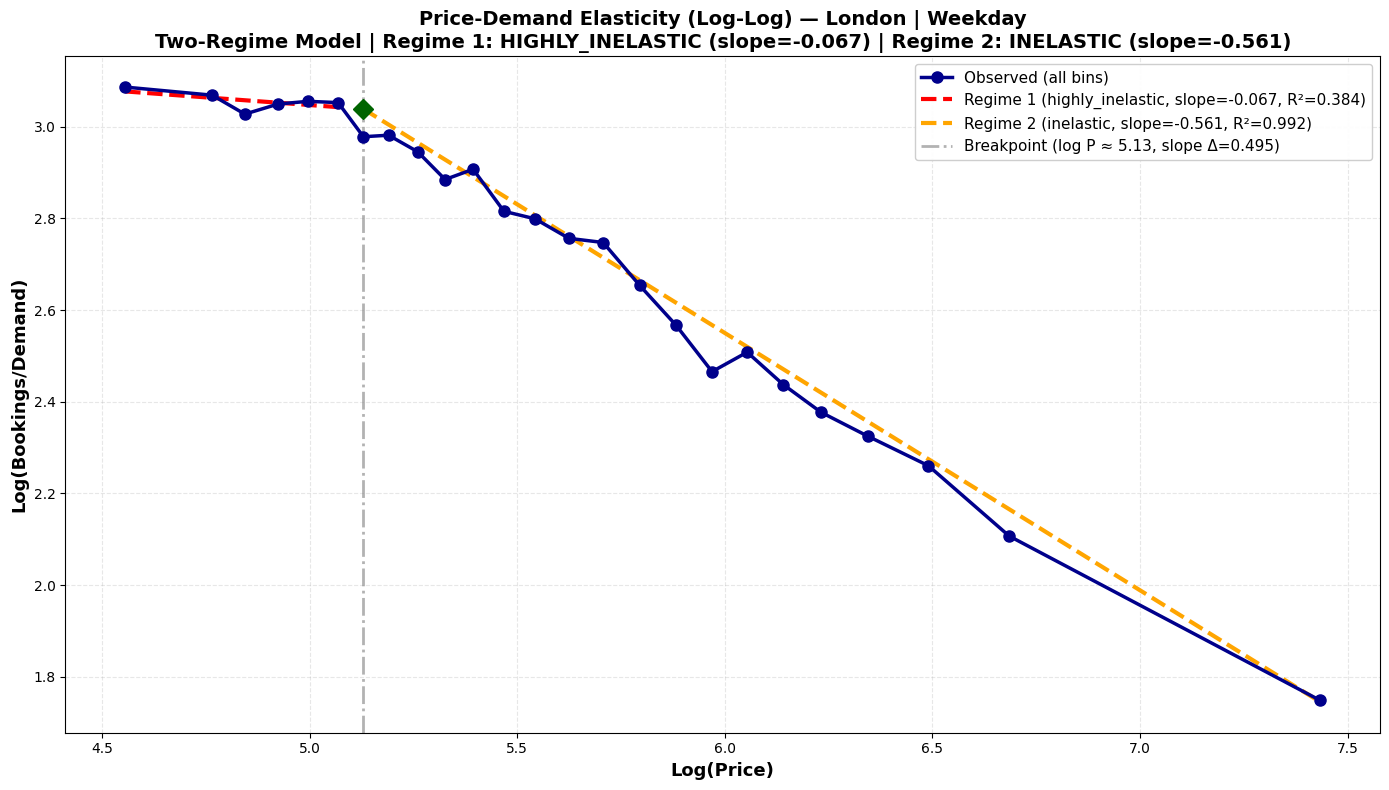


  WEEKEND:
    ✓ Two-regime fit detected (breakpoint at bin 7/25)
      Region 1 (7 bins): slope=-0.2632 (inelastic), R²=0.7421
      Region 2 (18 bins): slope=-0.6060 (inelastic), R²=0.9930
      Slope difference: 0.3428 | Breakpoint log(price)=5.2436 (price ~$189)


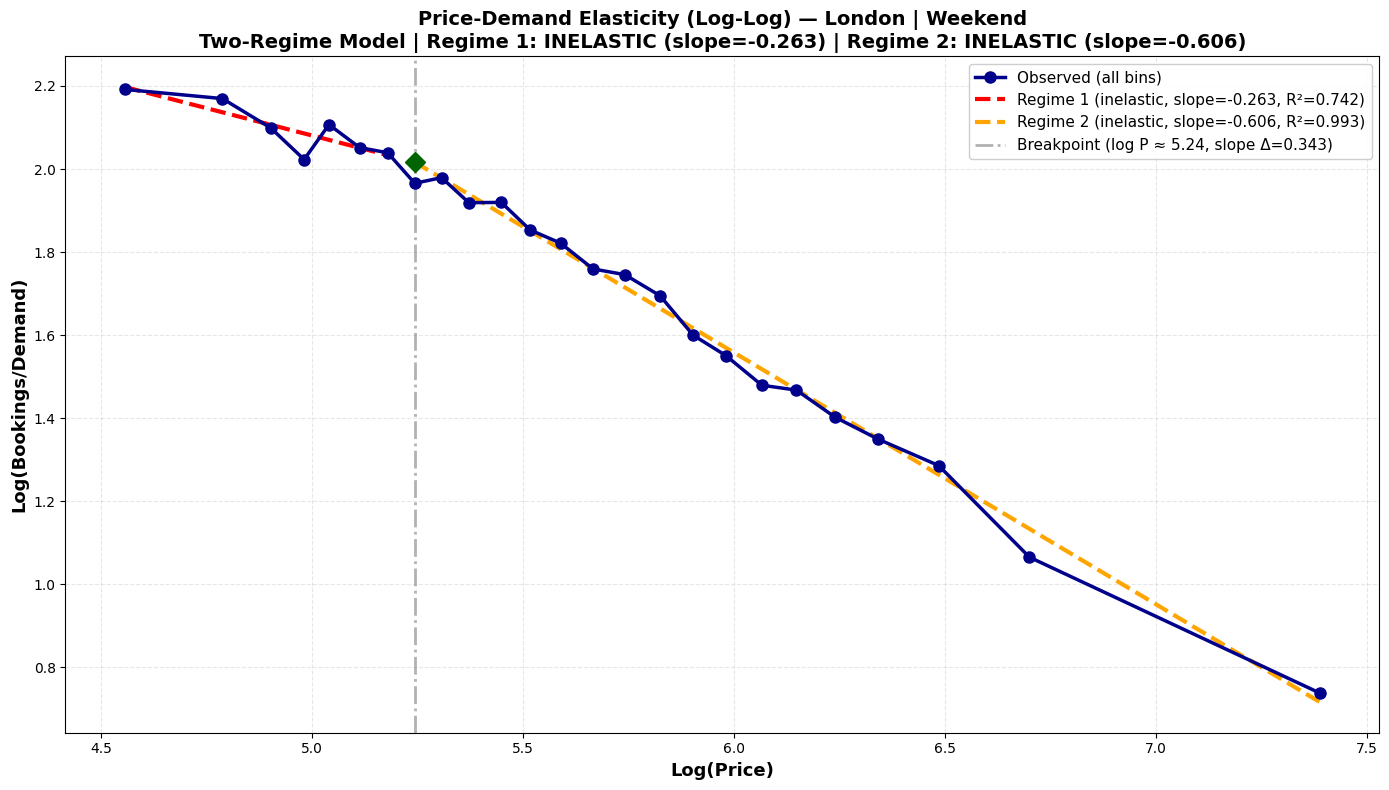


Processing elasticity for city: PARIS

  WEEKDAY:
    ✓ Single-regime fit (slope difference 0.2020 not significant enough)
      Slope=-0.5364 (inelastic), R²=0.9881


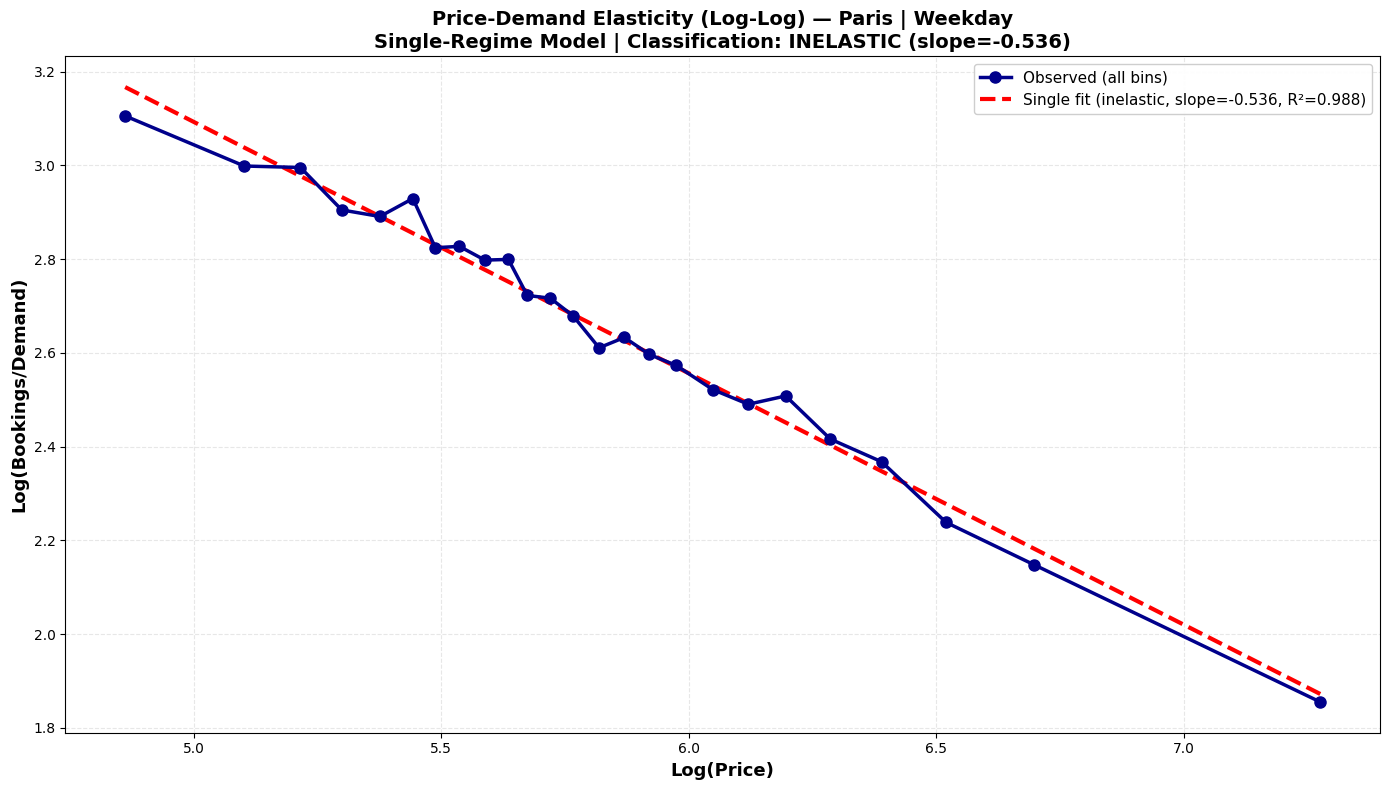


  WEEKEND:
    ✓ Single-regime fit (slope difference 0.1982 not significant enough)
      Slope=-0.5434 (inelastic), R²=0.9865


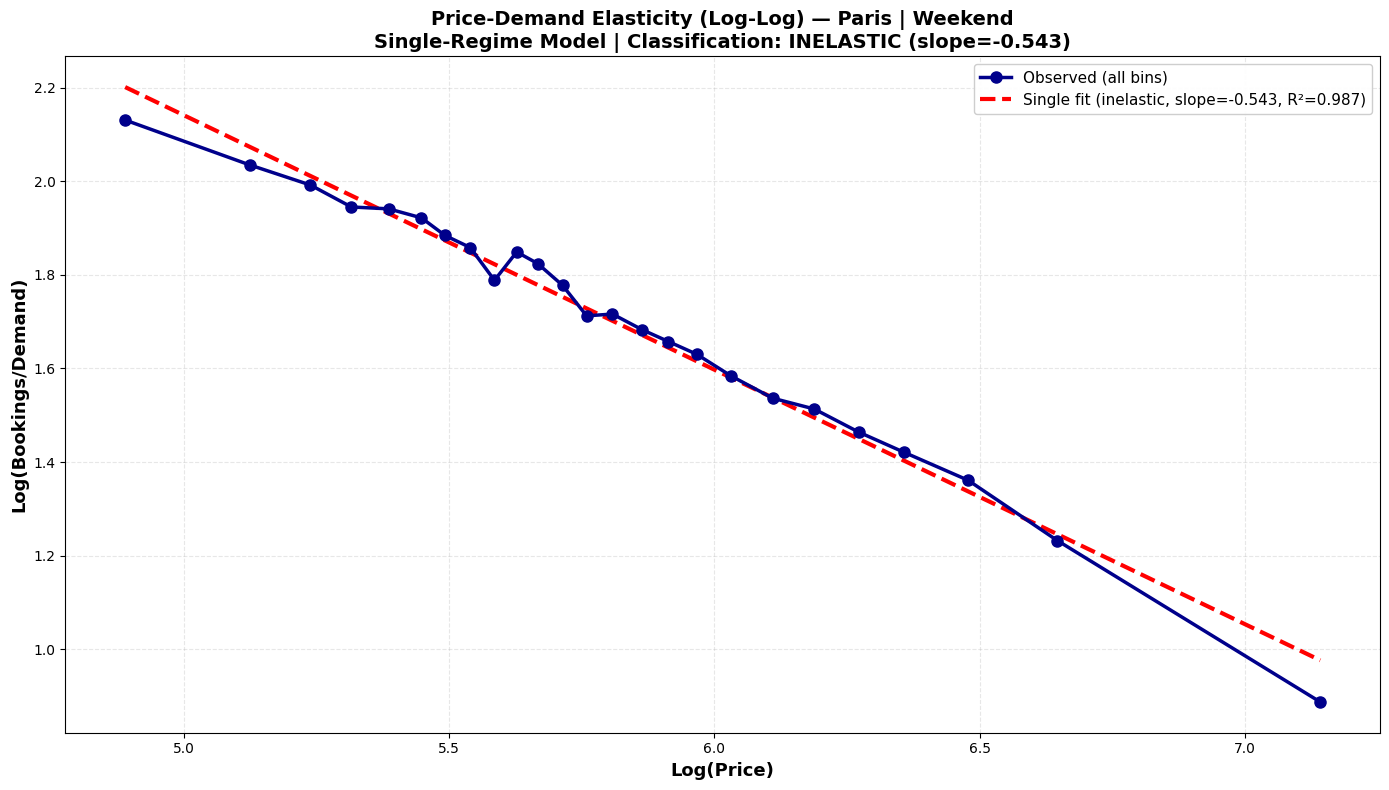


Processing elasticity for city: ROME

  WEEKDAY:
    ✓ Two-regime fit detected (breakpoint at bin 10/25)
      Region 1 (10 bins): slope=-0.0987 (highly_inelastic), R²=0.6243
      Region 2 (15 bins): slope=-0.4334 (inelastic), R²=0.9747
      Slope difference: 0.3348 | Breakpoint log(price)=5.1078 (price ~$165)


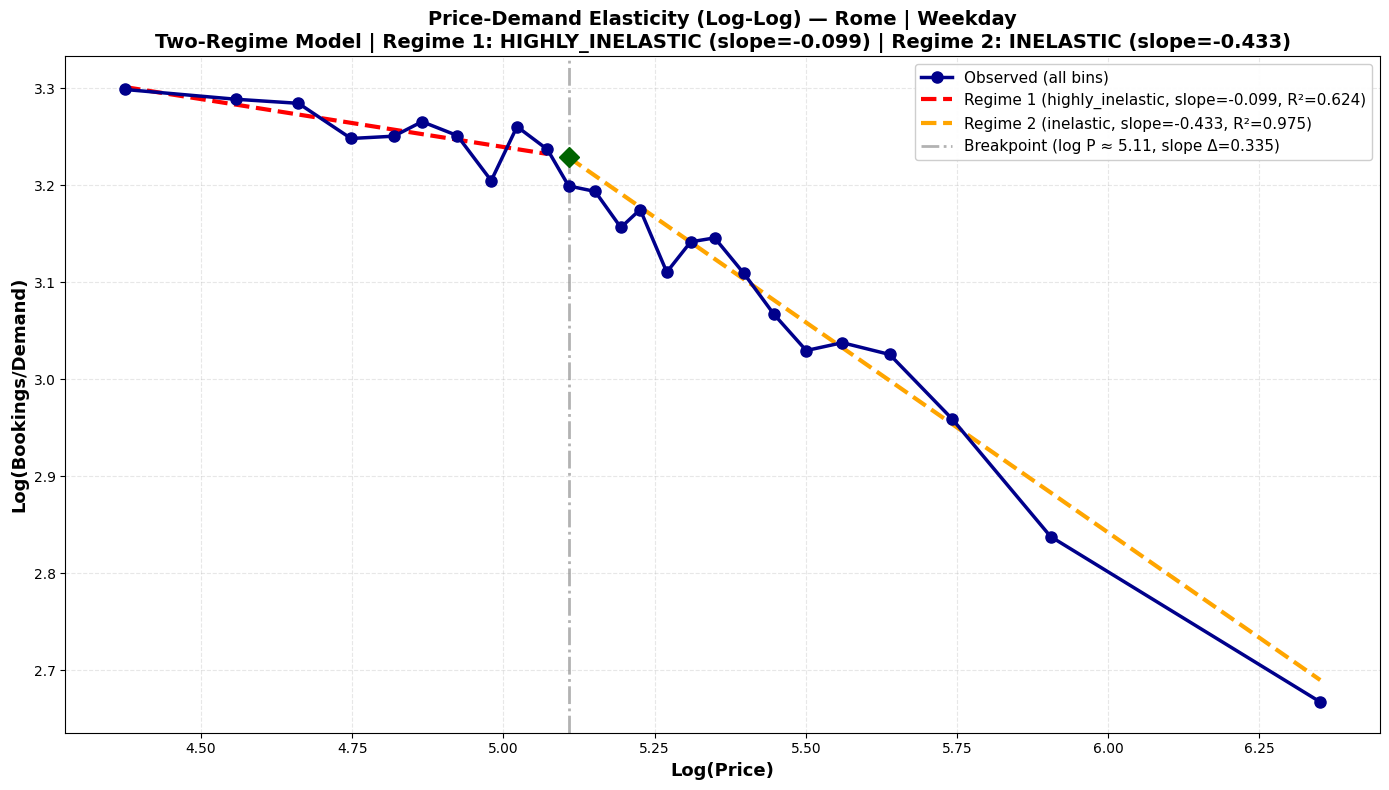


  WEEKEND:
    ✓ Two-regime fit detected (breakpoint at bin 4/25)
      Region 1 (4 bins): slope=-0.0656 (highly_inelastic), R²=0.3044
      Region 2 (21 bins): slope=-0.4389 (inelastic), R²=0.9579
      Slope difference: 0.3733 | Breakpoint log(price)=4.8421 (price ~$127)


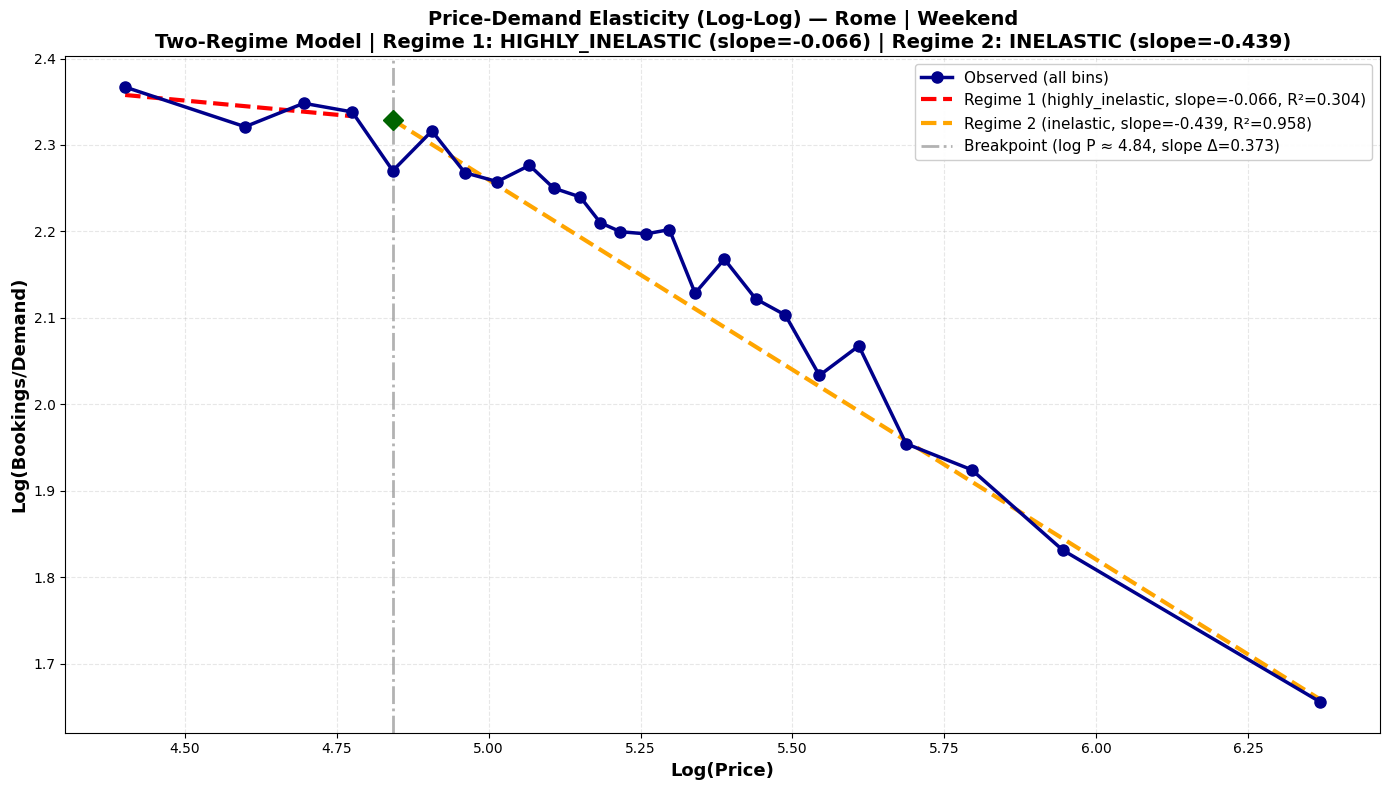


Processing elasticity for city: VIENNA

  WEEKDAY:
    ✓ Single-regime fit (slope difference 0.2243 not significant enough)
      Slope=-0.3189 (inelastic), R²=0.8882


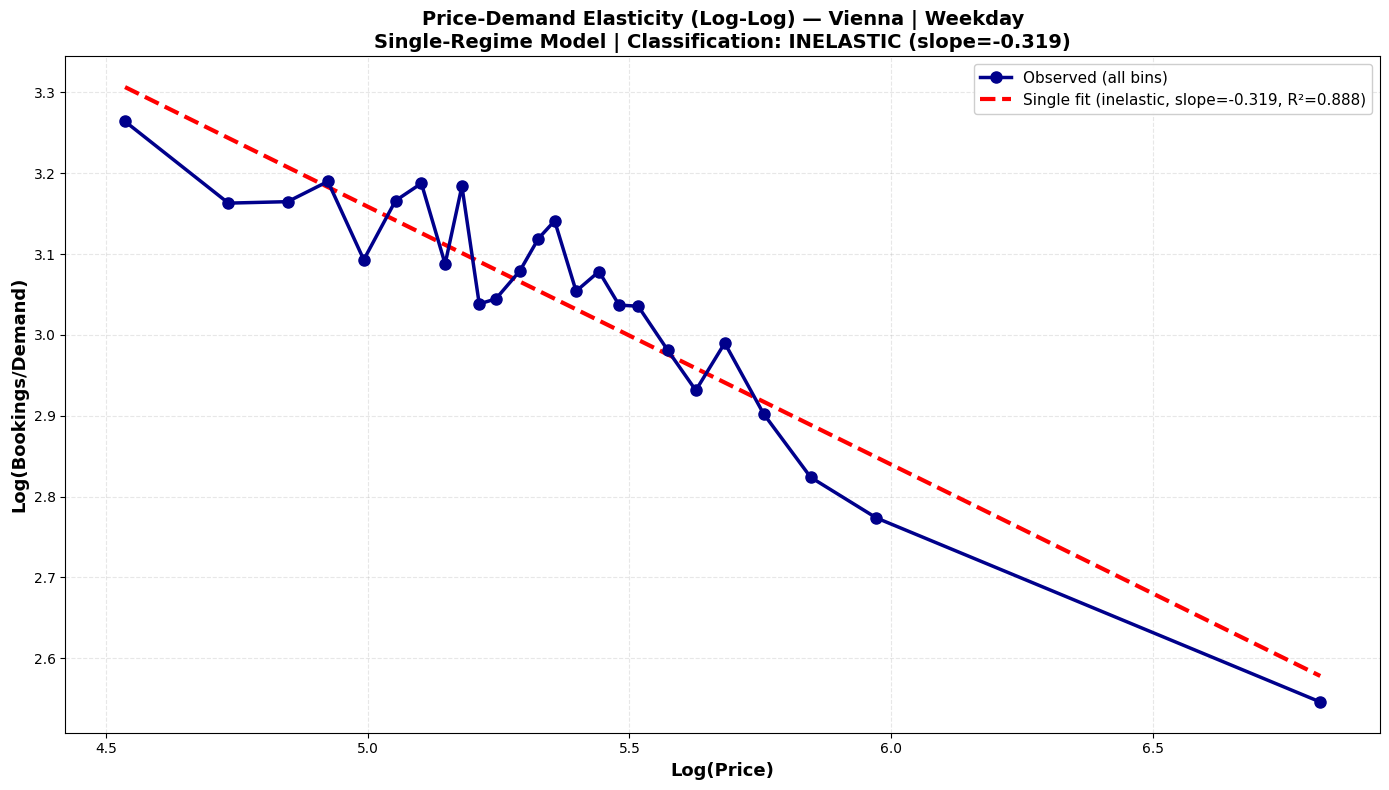


  WEEKEND:
    ✓ Two-regime fit detected (breakpoint at bin 14/25)
      Region 1 (14 bins): slope=-0.1955 (inelastic), R²=0.4526
      Region 2 (11 bins): slope=-0.5294 (inelastic), R²=0.9675
      Slope difference: 0.3339 | Breakpoint log(price)=5.4468 (price ~$232)


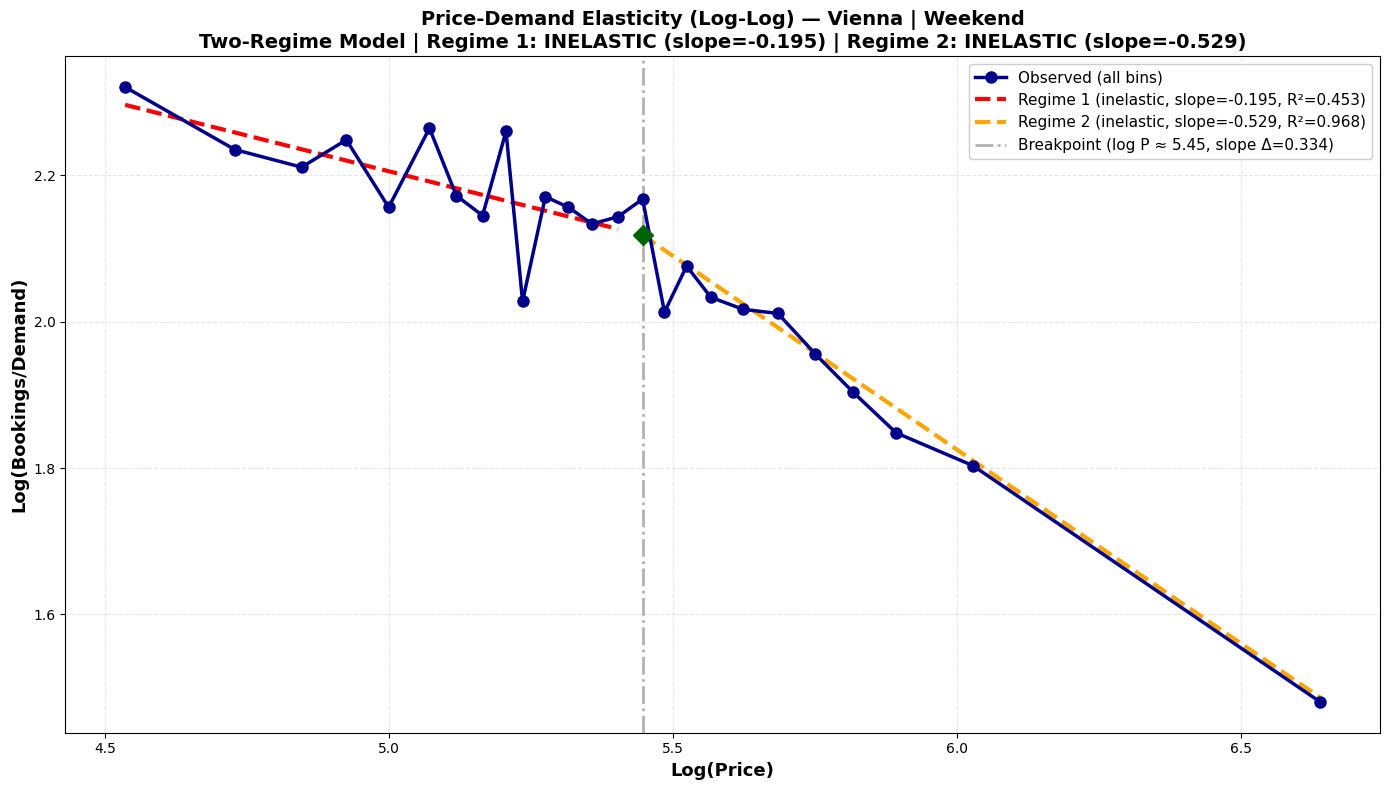


ELASTICITY SUMMARY TABLE



✓ Saved elasticity dict to: outputs/elasticities_by_segment.json
✓ Saved elasticity summary to: outputs/elasticity_summary.csv


In [12]:
# Log-log price-demand elasticity curve for each city (with weekend vs weekday comparison + adaptive breakpoint detection)

from pyspark.sql import functions as F
from pyspark.sql.window import Window
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
import json
from pathlib import Path

# Storage for elasticity estimates (segment → slope values)
elasticities_by_segment = {}

city_list = ['amsterdam', 'athens', 'barcelona', 'berlin', 'budapest', 'lisbon', 'london', 'paris', 'rome', 'vienna']

def classify_elasticity(slope):
    """
    Classify price elasticity of demand from log-log regression slope.
    
    In log-log space: slope = d(log Q) / d(log P) = price elasticity
    
    Economic theory foundation:
    - |E| > 1: elastic (quantity responds strongly to price)
    - |E| = 1: unit elastic (proportional response)
    - |E| < 1: inelastic (quantity responds weakly to price)
    
    Pragmatic classifications:
    - slope < -1.05: elastic 
      → 1% price ↑ causes >1.05% demand ↓ (strong price sensitivity)
    - -1.05 ≤ slope ≤ -0.95: unit_elastic
      → 1% price ↑ causes ≈1% demand ↓ (revenue stable, narrow band around -1)
    - -0.95 < slope < -0.15: inelastic
      → 1% price ↑ causes 0.15-0.95% demand ↓ (moderate price sensitivity)
    - -0.15 ≤ slope < 0.15: highly_inelastic
      → Near-zero price sensitivity (necessities, saturated markets)
    - slope ≥ 0.15: positive
      → Price ↑ increases demand (Giffen/Veblen goods, measurement error)
    
    Returns:
        str: elasticity category
    """
    if slope < -1.05:
        return "elastic"
    elif -1.05 <= slope <= -0.95:
        return "unit_elastic"
    elif -0.95 < slope < -0.15:
        return "inelastic"
    elif -0.15 <= slope < 0.15:
        return "highly_inelastic"
    else:
        return "positive"


for city in city_list:
    print(f"\n{'='*70}")
    print(f"Processing elasticity for city: {city.upper()}")
    print('='*70)
    
    df_city = df.where((F.col("listing_price").isNotNull()) & (F.col("city") == city))
    
    # Create price bins (20+ bins instead of deciles for better granularity)
    w = Window.orderBy(F.col("listing_price").asc())
    n_bins = 25  # Use 25 bins instead of 10 deciles
    df_binned = df_city.withColumn("price_bin", F.ntile(n_bins).over(w))
    
    # Create elasticity curve for each weekend segment
    for weekend_flag in [0, 1]:
        day_type = "weekend" if weekend_flag == 1 else "weekday"
        segment_key = f"{city}_{day_type}"
        
        print(f"\n  {day_type.upper()}:")
        
        df_city_wknd = df_city.where(F.col("weekend") == weekend_flag)
        
        # Create price bins for this segment
        w = Window.orderBy(F.col("listing_price").asc())
        df_binned_wknd = df_city_wknd.withColumn("price_bin", F.ntile(n_bins).over(w))
        
        price_bins_spark_wknd = (
            df_binned_wknd.groupBy("price_bin")
              .agg(
                  F.count("*").alias("listing_count"),
                  F.mean("listing_price").alias("avg_price"),
                  F.mean("n_bookings").alias("avg_bookings"),
              )
              .orderBy("price_bin")
        )
        
        elasticity_pdf = price_bins_spark_wknd.limit(5000).toPandas().sort_values("price_bin")
        
        # Log-log transformation
        elasticity_pdf["log_price"] = elasticity_pdf["avg_price"].apply(lambda x: np.log(x) if x > 0 else 0)
        elasticity_pdf["log_bookings"] = elasticity_pdf["avg_bookings"].apply(lambda x: np.log(x) if x > 0 else 0)
        
        # Filter out zero values
        elasticity_valid = elasticity_pdf[(elasticity_pdf["log_price"] > 0) & (elasticity_pdf["log_bookings"] > 0)].copy()
        elasticity_valid = elasticity_valid.reset_index(drop=True)
        
        if len(elasticity_valid) < 3:
            print(f"    ⚠ Skipping {day_type} (insufficient data points: {len(elasticity_valid)})")
            continue
        
        # ============================================================================
        # Detect Breakpoint: Search for slope changes across all windows
        # ============================================================================
        
        # Try all possible breakpoints and find the one with MOST DIFFERENT slopes
        best_breakpoint_idx = None
        best_slope_diff = 0
        best_r2_sum = 0
        
        min_region_size = np.max([2, len(elasticity_valid) // 6])  # At least ~4 points per region
        
        for breakpoint_idx in range(min_region_size, len(elasticity_valid) - min_region_size):
            region1 = elasticity_valid.iloc[:breakpoint_idx]
            region2 = elasticity_valid.iloc[breakpoint_idx:]
            
            # Fit both regions
            try:
                slope1, intercept1, r1, _, _ = stats.linregress(region1["log_price"], region1["log_bookings"])
                slope2, intercept2, r2, _, _ = stats.linregress(region2["log_price"], region2["log_bookings"])
            except:
                continue
            
            # Score: prioritize large slope differences (indicates regime change)
            # AND good fit quality in both regions
            slope_diff = abs(slope2 - slope1)
            r2_sum = r1**2 + r2**2
            
            # Weight: difference is primary, R² is tie-breaker
            score = slope_diff * 100 + r2_sum
            
            if score > (best_slope_diff * 100 + best_r2_sum):
                best_breakpoint_idx = breakpoint_idx
                best_slope_diff = slope_diff
                best_r2_sum = r2_sum
        
        # ============================================================================
        # Detect single or dual elasticity regimes
        # ============================================================================
        
        # Use two regimes if slope difference is significant (>0.3 in absolute terms)
        use_two_regimes = best_slope_diff > 0.3 and len(elasticity_valid) >= 6
        
        if use_two_regimes and best_breakpoint_idx is not None:
            region1 = elasticity_valid.iloc[:best_breakpoint_idx]
            region2 = elasticity_valid.iloc[best_breakpoint_idx:]
            
            slope1, intercept1, r1, _, _ = stats.linregress(region1["log_price"], region1["log_bookings"])
            slope2, intercept2, r2, _, _ = stats.linregress(region2["log_price"], region2["log_bookings"])
            
            # ========================================================================
            # ENSURE CONTINUITY AT BREAKPOINT: Adjust intercept of regime 2
            # ========================================================================
            breakpoint_price = elasticity_valid.iloc[best_breakpoint_idx]["log_price"]
            
            # Calculate y-value at breakpoint from regime 1
            y_at_breakpoint = slope1 * breakpoint_price + intercept1
            
            # Adjust regime 2's intercept so it passes through the breakpoint
            intercept2_adjusted = y_at_breakpoint - slope2 * breakpoint_price
            
            regime1_type = classify_elasticity(slope1)
            regime2_type = classify_elasticity(slope2)
            
            print(f"    ✓ Two-regime fit detected (breakpoint at bin {best_breakpoint_idx}/{len(elasticity_valid)})")
            print(f"      Region 1 ({len(region1)} bins): slope={slope1:.4f} ({regime1_type}), R²={r1**2:.4f}")
            print(f"      Region 2 ({len(region2)} bins): slope={slope2:.4f} ({regime2_type}), R²={r2**2:.4f}")
            print(f"      Slope difference: {best_slope_diff:.4f} | Breakpoint log(price)={breakpoint_price:.4f} (price ~${np.exp(breakpoint_price):.0f})")
            
            # Store both slopes for this segment
            elasticities_by_segment[segment_key] = {
                "n_bins": n_bins,
                "regimes": [
                    {
                        "name": regime1_type,
                        "slope": float(slope1),
                        "r_squared": float(r1**2),
                        "price_range": "lower",
                        "n_points": len(region1),
                        "log_price_min": float(region1["log_price"].min()),
                        "log_price_max": float(region1["log_price"].max()),
                    },
                    {
                        "name": regime2_type,
                        "slope": float(slope2),
                        "r_squared": float(r2**2),
                        "price_range": "upper",
                        "n_points": len(region2),
                        "log_price_min": float(region2["log_price"].min()),
                        "log_price_max": float(region2["log_price"].max()),
                    }
                ],
                "breakpoint_log_price": float(breakpoint_price),
                "breakpoint_price_approx": float(np.exp(breakpoint_price)),
                "slope_difference": float(best_slope_diff)
            }
            
            # Plot two-regime fit
            fig, ax = plt.subplots(figsize=(14, 8))
            
            # Plot observed curve
            ax.plot(elasticity_valid["log_price"], elasticity_valid["log_bookings"], 
                   marker="o", linewidth=2.5, markersize=8, color="darkblue", 
                   label="Observed (all bins)", zorder=3)
            
            # Plot regime 1 fit
            x1 = np.array(region1["log_price"])
            y1_fit = slope1 * x1 + intercept1
            ax.plot(x1, y1_fit, linewidth=3, linestyle="--", color="red", 
                   label=f"Regime 1 ({regime1_type}, slope={slope1:.3f}, R²={r1**2:.3f})", zorder=2)
            
            # Plot regime 2 fit (with adjusted intercept for continuity)
            x2 = np.array(region2["log_price"])
            y2_fit = slope2 * x2 + intercept2_adjusted
            ax.plot(x2, y2_fit, linewidth=3, linestyle="--", color="orange", 
                   label=f"Regime 2 ({regime2_type}, slope={slope2:.3f}, R²={r2**2:.3f})", zorder=2)
            
            # Breakpoint marker
            ax.axvline(breakpoint_price, color="gray", linestyle="-.", alpha=0.6, linewidth=2, 
                       label=f"Breakpoint (log P ≈ {breakpoint_price:.2f}, slope Δ={best_slope_diff:.3f})")
            ax.plot(breakpoint_price, y_at_breakpoint, marker="D", markersize=10, color="darkgreen", zorder=4)
            
            ax.set_xlabel("Log(Price)", fontsize=13, fontweight="bold")
            ax.set_ylabel("Log(Bookings/Demand)", fontsize=13, fontweight="bold")
            ax.set_title(
                f"Price-Demand Elasticity (Log-Log) — {city.capitalize()} | {day_type.capitalize()}\n"
                f"Two-Regime Model | Regime 1: {regime1_type.upper()} (slope={slope1:.3f}) | Regime 2: {regime2_type.upper()} (slope={slope2:.3f})",
                fontsize=14, fontweight="bold"
            )
            ax.grid(True, alpha=0.3, linestyle="--")
            ax.legend(loc="best", fontsize=11, framealpha=0.95)
            plt.tight_layout()
            plt.savefig(output_dir / f"elasticity_loglog_{city}_{day_type}_2regime.png", dpi=150)
            plt.show()
            
        else:
            # Single-regime fit
            slope_full, intercept_full, r_value_full, p_value_full, std_err_full = stats.linregress(
                elasticity_valid["log_price"], 
                elasticity_valid["log_bookings"]
            )
            
            regime_type = classify_elasticity(slope_full)
            print(f"    ✓ Single-regime fit (slope difference {best_slope_diff:.4f} not significant enough)")
            print(f"      Slope={slope_full:.4f} ({regime_type}), R²={r_value_full**2:.4f}")
            
            elasticities_by_segment[segment_key] = {
                "n_bins": n_bins,
                "regimes": [
                    {
                        "name": regime_type,
                        "slope": float(slope_full),
                        "r_squared": float(r_value_full**2),
                        "price_range": "full",
                        "n_points": len(elasticity_valid),
                        "log_price_min": float(elasticity_valid["log_price"].min()),
                        "log_price_max": float(elasticity_valid["log_price"].max()),
                    }
                ],
                "breakpoint_log_price": None,
                "breakpoint_price_approx": None,
                "slope_difference": None
            }
            
            # Plot single-regime fit
            fig, ax = plt.subplots(figsize=(14, 8))
            
            # Plot observed curve
            ax.plot(elasticity_valid["log_price"], elasticity_valid["log_bookings"], 
                   marker="o", linewidth=2.5, markersize=8, color="darkblue", 
                   label="Observed (all bins)", zorder=3)
            
            # Plot fit line
            x_full = np.array(elasticity_valid["log_price"])
            y_full_fit = slope_full * x_full + intercept_full
            ax.plot(x_full, y_full_fit, linewidth=3, linestyle="--", color="red", 
                   label=f"Single fit ({regime_type}, slope={slope_full:.3f}, R²={r_value_full**2:.3f})", zorder=2)
            
            ax.set_xlabel("Log(Price)", fontsize=13, fontweight="bold")
            ax.set_ylabel("Log(Bookings/Demand)", fontsize=13, fontweight="bold")
            ax.set_title(
                f"Price-Demand Elasticity (Log-Log) — {city.capitalize()} | {day_type.capitalize()}\n"
                f"Single-Regime Model | Classification: {regime_type.upper()} (slope={slope_full:.3f})",
                fontsize=14, fontweight="bold"
            )
            ax.grid(True, alpha=0.3, linestyle="--")
            ax.legend(loc="best", fontsize=11, framealpha=0.95)
            plt.tight_layout()
            plt.savefig(output_dir / f"elasticity_loglog_{city}_{day_type}_1regime.png", dpi=150)
            plt.show()

# ============================================================================
# SAVE ELASTICITY DICTIONARY FOR REVENUE OPTIMIZATION
# ============================================================================

print(f"\n{'='*70}")
print("ELASTICITY SUMMARY TABLE")
print('='*70)

# Pretty-print elasticity table
elasticity_summary = []
for segment_key, data in elasticities_by_segment.items():
    for i, regime in enumerate(data["regimes"], 1):
        elasticity_summary.append({
            "segment": segment_key,
            "regime": i,
            "regime_type": regime["name"],  # Now just the type, not "1_type"
            "slope": regime["slope"],
            "r_squared": regime["r_squared"],
            "n_bins": regime["n_points"],
            "price_range": regime["price_range"],
            "log_price_min": regime.get("log_price_min"),
            "log_price_max": regime.get("log_price_max"),
        })

elasticity_summary_df = pd.DataFrame(elasticity_summary)

fmt_elasticity = {
    "slope": "{:.4f}",
    "r_squared": "{:.4f}",
    "log_price_min": "{:.4f}",
    "log_price_max": "{:.4f}",
}

display(
    elasticity_summary_df.style.format(fmt_elasticity)
                                .set_table_attributes("style='width:90%; font-family: Arial; font-size:12px;'")
                                .set_caption("Elasticity estimates by segment (city × day_type)")
)

# Save to JSON
elasticity_json_path = output_dir / "elasticities_by_segment.json"
with open(elasticity_json_path, "w") as f:
    json.dump(elasticities_by_segment, f, indent=2)

print(f"\n✓ Saved elasticity dict to: outputs/elasticities_by_segment.json")

# Save summary table to CSV
elasticity_csv_path = output_dir / "elasticity_summary.csv"
elasticity_summary_df.to_csv(elasticity_csv_path, index=False)
print(f"✓ Saved elasticity summary to: outputs/elasticity_summary.csv")

In [13]:
# Summary Statistics by Segment (Spark groupBy + robust metrics + export)

from pyspark.sql import functions as F
import pandas as pd

# Create day_type column from weekend flag
df_with_day_type = df.withColumn("day_type", F.when(F.col("weekend") == 1, "weekend").otherwise("weekday"))

summary_spark = (
    df_with_day_type.groupBy("city", "day_type")
      .agg(
          F.count("*").alias("n"),
          F.mean("listing_price").alias("avg_price"),
          F.expr("percentile_approx(listing_price, 0.5)").alias("median_price"),
          F.stddev("listing_price").alias("price_std"),
          F.expr("percentile_approx(listing_price, 0.1)").alias("p10_price"),
          F.expr("percentile_approx(listing_price, 0.9)").alias("p90_price"),
          F.mean("guest_satisfaction_overall").alias("avg_satisfaction"),
          F.mean("cleanliness_rating").alias("avg_cleanliness"),
          F.mean("city_center_dist").alias("avg_distance"),
          F.mean("metro_dist").alias("avg_metro_distance"),
          F.mean("person_capacity").alias("avg_capacity"),
          F.mean(F.col("host_is_superhost").cast("double")).alias("superhost_rate"),
      )
      .orderBy("city", "day_type")
)

# Pretty-print Spark aggregate via a styled Pandas DataFrame (safe limit + formatting)
summary_pdf = summary_spark.limit(5000).toPandas().sort_values(["city", "day_type"])
summary_pdf["n"] = summary_pdf["n"].astype(int)

# Format dictionary for display
fmt_summary = {
    "n": "{:,}",
    "avg_price": "{:,.2f}",
    "median_price": "{:,.2f}",
    "price_std": "{:,.2f}",
    "p10_price": "{:,.2f}",
    "p90_price": "{:,.2f}",
    "avg_satisfaction": "{:.2f}",
    "avg_cleanliness": "{:.2f}",
    "avg_distance": "{:,.2f}",
    "avg_metro_distance": "{:,.2f}",
    "avg_capacity": "{:.2f}",
    "superhost_rate": "{:.2%}",
}

display(
    summary_pdf.style.format(fmt_summary)
                       .set_table_attributes("style='width:90%; font-family: Arial; font-size:12px;'")
                       .set_caption("Summary statistics by city x day_type (Spark → Pandas)")
)

# Save outputs
output_dir = project_root / "outputs"
output_dir.mkdir(parents=True, exist_ok=True)

# 1) CSV via Pandas (single file  with sample limit)
summary_pdf.to_csv(output_dir / "summary_statistics_by_segment_limit_5000.csv", index=False)

# 2) CSV via Spark (folder output, scalable)
(
    summary_spark.coalesce(1)
    .write.mode("overwrite")
    .option("header", "true")
    .csv(str(output_dir / "summary_statistics_by_segment_spark"))
)

print(f"Saved:\n- {'outputs/summary_statistics_by_segment_limit_5000.csv'}\n- {'outputs/summary_statistics_by_segment_spark'}")

Saved:
- outputs/summary_statistics_by_segment_limit_5000.csv
- outputs/summary_statistics_by_segment_spark
